In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook
import scipy.io as sio
import pyute as ut
from importlib import reload
reload(ut)
import h5py
import matplotlib.cm as cm
import scipy.stats as sst
import scipy.ndimage.filters as sfi
import sklearn.metrics as skm
from oasis.functions import deconvolve
from oasis import oasisAR1, oasisAR2

import scipy.signal as ssi
from matplotlib import rc
import scipy.optimize as sop
import pylab

/home/mossing/Documents/code/downloads/OASIS/oasis/functions.py:14: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  "just not the slower interior point methods we compared to in the papers.")


In [2]:
# datafold = '/home/mossing/excitation/2P/170904/M7194/'
# datafile = 'trialwise_001.mat'
# datafold = '/home/mossing/scratch/2Pdata/180216/M7307/ot/'
# datafiles = ['M7307_120_003_ot_000.rois','M7307_120_003_ot_001.rois',
#              'M7307_120_003_ot_002.rois','M7307_120_003_ot_003.rois']
# stimfold = '/home/mossing/excitation/visual_stim/180216/M7307/'
# stimfile = 'M7307_120_003.mat'

thisfold = '180216/M7307/'
thisfile = 'M7307_120_003'

datafoldbase = '/home/mossing/scratch/2Pdata/'
datafold = datafoldbase+thisfold+'ot/'
datafiles = [thisfile+'_ot_'+number+'.rois' for number in ['000','001','002','003']]

stimfoldbase = '/home/mossing/excitation/visual_stim/'
stimfold = stimfoldbase+thisfold
stimfile = thisfile+'.mat'

In [3]:
# with h5py.File(datafold+datafile,mode='r') as f:
#             F = f['corrected'][:].T

In [4]:
# ds = 10
# baseline = sfi.percentile_filter(F[:,::ds],5,(1,int(3000/ds)))
# baseline = np.repeat(baseline,ds,axis=1)

In [5]:
# baseline.shape

In [6]:
# k = 4
# plt.plot(F[k])
# plt.plot(baseline[k])

In [7]:
blcutoff = 5
ds = 10
blspan = 3000
nbefore = 0
nafter = 0
trialwise = np.array(())
ctrialwise = np.array(())
strialwise = np.array(())
try:
    for datafile in datafiles:
        frm = sio.loadmat(datafold+datafile.replace('.rois','.mat'),squeeze_me=True)['info']['frame'][()][1:-1]
        to_add = sio.loadmat(datafold+datafile,squeeze_me=True)['corrected']
#         baseline = np.percentile(to_add,blcutoff,axis=1)
        baseline = sfi.percentile_filter(to_add[:,::ds],blcutoff,(1,int(blspan/ds)))
        baseline = np.repeat(baseline,ds,axis=1)
#         if baseline.shape[1]<to_add.shape[1]:
#             baseline = np.hstack((baseline,np.repeat(baseline[:,-1],to_add.shape[1]-baseline.shape[1])))
        if baseline.shape[1]>to_add.shape[1]:
            baseline = baseline[:,:to_add.shape[1]]
        c = np.zeros_like(to_add)
        s = np.zeros_like(to_add)
        for i in range(c.shape[0]):
#                 dfof = (to_add[i]-baseline[i,np.newaxis])/baseline[i,np.newaxis]
            dfof = (to_add[i]-baseline[i,:])/baseline[i,:]
            c[i],s[i],_,_,_  = deconvolve(dfof,penalty=1)
        to_add = ut.trialize(to_add,frm,nbefore,nafter)
        c = ut.trialize(c,frm,nbefore,nafter)
        s = ut.trialize(s,frm,nbefore,nafter)
        try:
            trialwise = np.concatenate((trialwise,to_add),axis=0)
            ctrialwise = np.concatenate((ctrialwise,c),axis=0)
            strialwise = np.concatenate((strialwise,s),axis=0)
        except:
            trialwise = to_add.copy()
            ctrialwise = np.concatenate((ctrialwise,c),axis=0)
            strialwise = np.concatenate((strialwise,s),axis=0)
except:
    for datafile in datafiles:
        frm = sio.loadmat(datafold+datafile.replace('.rois','.mat'),squeeze_me=True)['info']['frame'][()][1:-1]
        with h5py.File(datafold+datafile,mode='r') as f:
            to_add = f['corrected'][:].T
#             baseline = np.percentile(to_add,blcutoff,axis=1)
            baseline = sfi.percentile_filter(to_add[:,::ds],blcutoff,(1,int(blspan/ds)))
            baseline = np.repeat(baseline,ds,axis=1)
#             if baseline.shape[1]<to_add.shape[1]:
#                 baseline = np.hstack((baseline,np.repeat(baseline[:,-1],to_add.shape[1]-baseline.shape[1])))
            if baseline.shape[1]>to_add.shape[1]:
                baseline = baseline[:,:to_add.shape[1]]
            c = np.zeros_like(to_add)
            s = np.zeros_like(to_add)
            for i in range(c.shape[0]):
#                 dfof = (to_add[i]-baseline[i,np.newaxis])/baseline[i,np.newaxis]
                dfof = (to_add[i]-baseline[i,:])/baseline[i,:]
                c[i],s[i],_,_,_  = deconvolve(dfof,penalty=1)
            to_add = ut.trialize(to_add,frm,nbefore,nafter)
            c = ut.trialize(c,frm,nbefore,nafter)
            s = ut.trialize(s,frm,nbefore,nafter)
            try:
                trialwise = np.concatenate((trialwise,to_add),axis=0)
                ctrialwise = np.concatenate((ctrialwise,c),axis=0)
                strialwise = np.concatenate((strialwise,s),axis=0)
            except:
                trialwise = to_add.copy()
                ctrialwise = c.copy()
                strialwise = s.copy()

In [35]:
zstrialwise = sst.zscore(strialwise.reshape((strialwise.shape[0],-1)).T).T.reshape(strialwise.shape)

In [8]:
strialwise.shape

(1116, 640, 8)

<IPython.core.display.Javascript object>


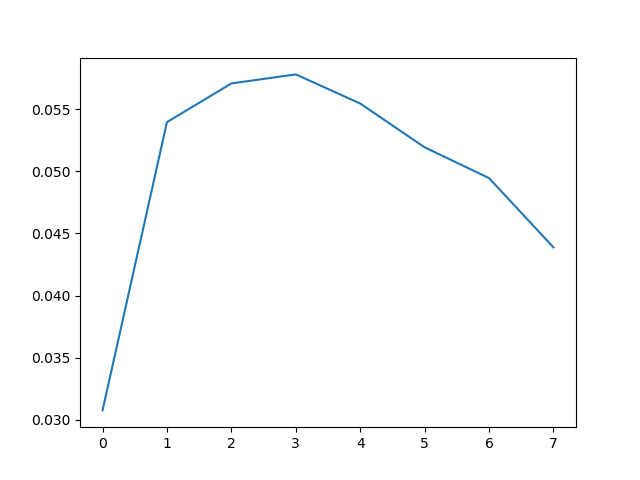

In [9]:
plt.plot(strialwise.mean(0).mean(0))

In [10]:
try:
    trialrun = sio.loadmat(datafold+datafile,squeeze_me=True)['trialrunning']
except:
    with h5py.File(datafold+datafiles[0],mode='r') as f:
        trialrun = f['trialrun'][:].T

In [11]:
trialrun.shape

(640, 7)

<IPython.core.display.Javascript object>


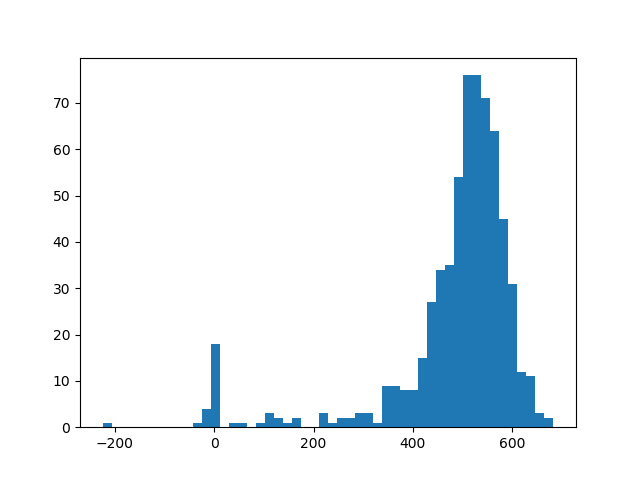

In [12]:
plt.figure()
plt.hist(trialrun.mean(1),bins=50)
running = trialrun.mean(1)>200

In [13]:
matfile = sio.loadmat(stimfold+stimfile,squeeze_me=True)
stimparams = matfile['result'][()]['stimParams']
stimparams[np.isnan(stimparams)] = -1
stimparams

array([[  4.50000000e+01,   1.35000000e+02,   9.00000000e+01, ...,
          4.50000000e+01,   2.70000000e+02,   1.35000000e+02],
       [  6.00000000e+01,   3.00000000e+01,   6.00000000e+01, ...,
          6.00000000e+01,   6.00000000e+01,   1.50000000e+01],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  8.00000000e-02,   8.00000000e-02,   8.00000000e-02, ...,
          8.00000000e-02,   8.00000000e-02,   8.00000000e-02],
       [  5.00000000e-01,   1.25000000e-01,   1.00000000e+00, ...,
          2.50000000e-01,   5.00000000e-01,   1.25000000e-01]])

In [14]:
# sorting = ut.sortbymultiple([stimparams[0],stimparams[1]])
indexlut,stimp = np.unique(stimparams,axis=1,return_inverse=True)

In [15]:
angle = stimparams[0]
size = stimparams[1]
contrast = stimparams[4]

In [16]:
strialwise.shape

(1116, 640, 8)

<IPython.core.display.Javascript object>


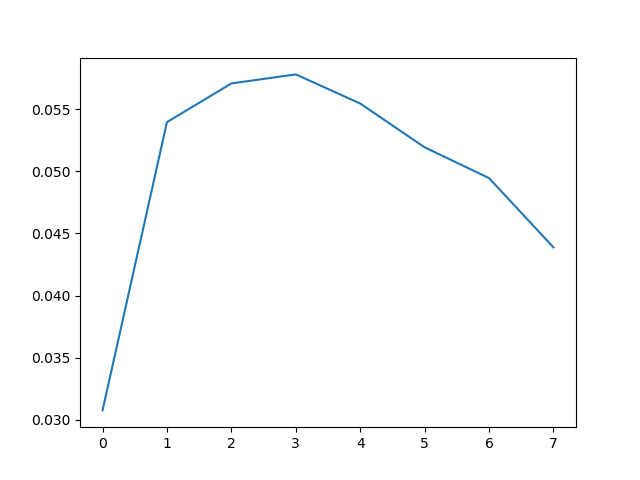

In [17]:
plt.figure()
plt.plot(strialwise.mean(0).mean(0))

In [45]:
pct0 = zstrialwise[:,:,:3].mean(-1).mean(-1)

In [46]:
pct0

array([ 0.05979845,  0.06200143,  0.03043051, ...,  0.12314681,
       -0.05936437, -0.07550193])

<IPython.core.display.Javascript object>


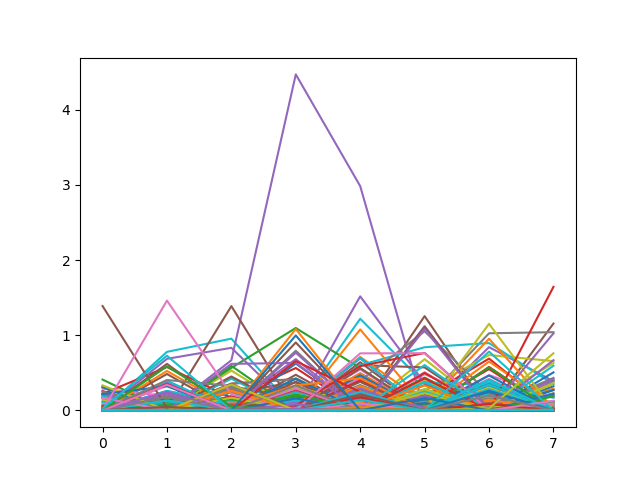

In [20]:
plt.figure()
plt.plot(strialwise[95].T)

In [22]:
np.arange(0,360,45)

array([  0,  45,  90, 135, 180, 225, 270, 315])

<IPython.core.display.Javascript object>


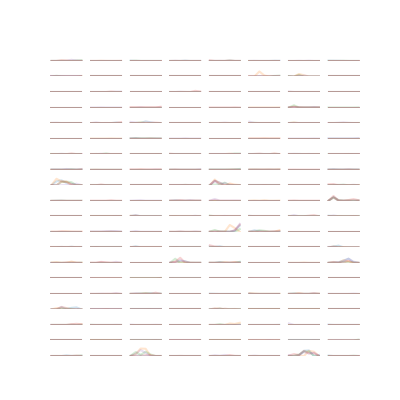

In [23]:
plt.figure(figsize=(4,4))
for j,nind in enumerate(np.arange(90,110)):
    for i,theta in enumerate(np.arange(0,360,45)):
        plt.subplot(20,8,j*8+i+1)
        plt.plot(strialwise[nind,np.logical_and(contrast==1,np.logical_and(angle==theta,size==60)),:-1].T,alpha=0.2)
        plt.ylim((0,10))
        plt.axis('off')

<IPython.core.display.Javascript object>


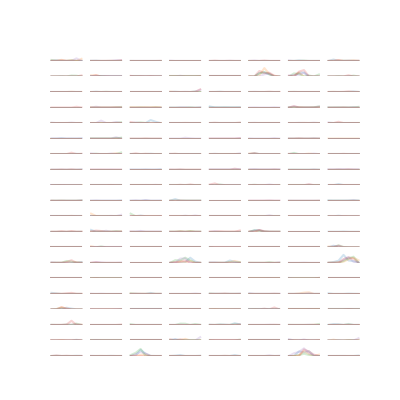

In [24]:
plt.figure(figsize=(4,4))
for j,nind in enumerate(np.arange(90,110)):
    for i,theta in enumerate(np.arange(0,360,45)):
        plt.subplot(20,8,j*8+i+1)
        plt.plot(strialwise[nind,np.logical_and(contrast==1,np.logical_and(angle==theta,size==30)),:-1].T,alpha=0.2)
        plt.ylim((0,10))
        plt.axis('off')

<IPython.core.display.Javascript object>


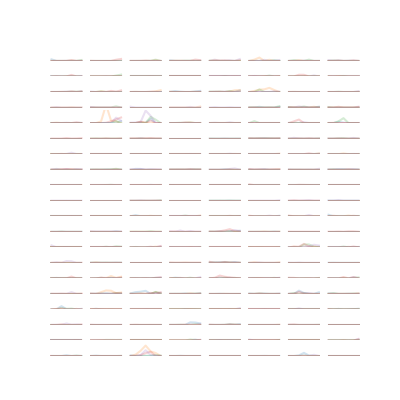

In [25]:
plt.figure(figsize=(4,4))
for j,nind in enumerate(np.arange(90,110)):
    for i,theta in enumerate(np.arange(0,360,45)):
        plt.subplot(20,8,j*8+i+1)
        plt.plot(strialwise[nind,np.logical_and(contrast==1,np.logical_and(angle==theta,size==15)),:-1].T,alpha=0.2)
        plt.ylim((0,10))
        plt.axis('off')

<IPython.core.display.Javascript object>


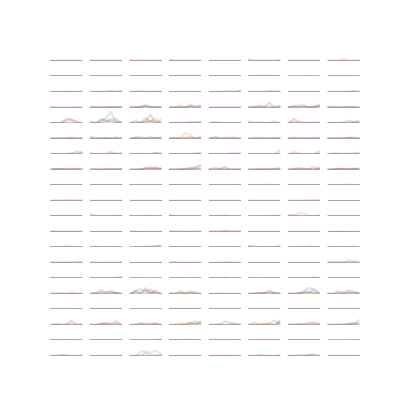

In [19]:
plt.figure(figsize=(4,4))
for j,nind in enumerate(np.arange(90,110)):
    for i,theta in enumerate(np.arange(0,360,45)):
        plt.subplot(20,8,j*8+i+1)
        plt.plot(strialwise[nind,np.logical_and(contrast==1,np.logical_and(angle==theta,size==7.5)),:-1].T,alpha=0.2)
        plt.ylim((0,10))
        plt.axis('off')

In [26]:
strialwise.shape

(1116, 640, 8)

In [27]:
smean = strialwise.mean(2)

In [28]:
np.unique(contrast)

array([ 0.125,  0.25 ,  0.5  ,  1.   ])

In [29]:
ucontrast = np.unique(contrast)
uangle = np.unique(angle)
usize = np.unique(size)
ncontrast = len(ucontrast)
nangle = len(uangle)
nsize = len(usize)

In [36]:
Smean = np.zeros((strialwise.shape[0],nangle,nsize,ncontrast,strialwise.shape[2]))
Stavg = np.zeros((strialwise.shape[0],nangle,nsize,ncontrast,int(strialwise.shape[1]/nangle/nsize/ncontrast)))

In [37]:
for i in range(nangle):
    for j in range(nsize):
        for k in range(ncontrast):
            lkat = np.logical_and(angle==uangle[i],np.logical_and(contrast==ucontrast[k],size==usize[j]))
            Smean[:,i,j,k,:] = zstrialwise[:,lkat,:].mean(1)
            Stavg[:,i,j,k,:] = zstrialwise[:,lkat,:].mean(2)
Strials = Stavg.mean(1)

In [74]:
Storiavg = Stavg.mean(1)
_,pval = sst.ttest_ind(Storiavg[:,0,-1].T,Storiavg[:,0,0].T)

In [75]:
Storiavg[:,0,-1].shape

(1116, 5)

In [76]:
lkat = pval<0.05

In [40]:
Savg = Smean.mean(-1).mean(1)

In [41]:
lb_lkat,ub_lkat = ut.bootstrap(Savg[lkat],np.mean,axis=0,pct=(16,84))
mn_lkat = Savg[lkat].mean(0)
errorplus = ub_lkat-mn_lkat
errorminus = mn_lkat-lb_lkat

matdict = {}
matdict['errorU'] = errorplus
matdict['errorL'] = errorminus
matdict['leg'] = [str(int(round(x)))+' deg.' for x in usize]
matdict['data'] = mn_lkat
matdict['labelX'] = 'contrast (%)'
matdict['labelY'] = 'avg. event rate'
matdict['x'] = 100*ucontrast
sio.savemat('pc_size_contrast.mat',matdict)

In [42]:
lb_lkat,ub_lkat = ut.bootstrap(Savg[lkat].transpose((0,2,1))[:,::-1],np.mean,axis=0,pct=(16,84))
mn_lkat = Savg[lkat].transpose((0,2,1))[:,::-1].mean(0)
errorplus = ub_lkat-mn_lkat
errorminus = mn_lkat-lb_lkat

matdict = {}
matdict['errorU'] = errorplus
matdict['errorL'] = errorminus
matdict['leg'] = [str(int(round(100*x)))+'%' for x in ucontrast[::-1]]
matdict['data'] = mn_lkat
matdict['labelX'] = 'size (deg.)'
matdict['labelY'] = 'avg. event rate'
matdict['x'] = usize
sio.savemat('pc_contrast_size.mat',matdict)

In [43]:
errorplus.shape

(4, 4)

In [63]:
_,pval = sst.ttest_ind(Savg[:,0,0],Savg[:,0,-1])

In [69]:
pval

4.0816208176524186e-07

In [64]:
lkat = pval<0.05

In [47]:
lb_lkat,ub_lkat = ut.bootstrap(Savg[lkat],np.mean,axis=0,pct=(16,84))
lb0,ub0 = ut.bootstrap(pct0[lkat],np.mean,axis=0,pct=(16,84))

mn_lkat = Savg[lkat].mean(0)

mn0 = np.tile(pct0[lkat].mean(),(4,1))
lb0 = np.tile(lb0,(4,1))
ub0 = np.tile(ub0,(4,1))

mx = mn_lkat.max()

errorplus = np.concatenate((ub0-mn0,ub_lkat-mn_lkat),axis=1)
errorminus = np.concatenate((mn0-lb0,mn_lkat-lb_lkat),axis=1)


matdict = {}
matdict['errorU'] = errorplus[1,:]/mx
matdict['errorL'] = errorminus[1,:]/mx
# matdict['leg'] = [str(int(round(x)))+' deg.' for x in usize]
matdict['data'] = np.concatenate((mn0[1,:],mn_lkat[1,:]),axis=0)/mx
matdict['labelX'] = 'contrast (%)'
matdict['labelY'] = 'norm. event rate'
matdict['x'] = np.concatenate(((0,),100*ucontrast))
sio.savemat('pc_with_0_contrast.mat',matdict)

In [68]:
lkat.shape

()

<IPython.core.display.Javascript object>


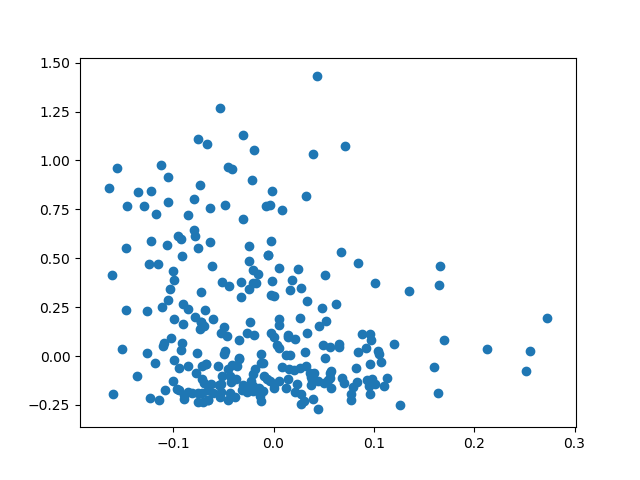

In [77]:
plt.figure()
plt.scatter(pct0[lkat],Savg[lkat][:,0,-1])

In [48]:
lb_lkat,ub_lkat = ut.bootstrap(Savg[lkat],np.mean,axis=0,pct=(16,84))
mn_lkat = Savg[lkat].mean(0)
errorplus = ub_lkat-mn_lkat
errorminus = mn_lkat-lb_lkat

# matdict = {}
# matdict['errorU'] = errorplus
# matdict['errorL'] = errorminus
# matdict['leg'] = [str(int(round(x)))+' deg.' for x in usize]
# matdict['data'] = mn_lkat
# matdict['labelX'] = 'contrast (%)'
# matdict['labelY'] = 'avg. event rate'
# matdict['x'] = 100*ucontrast
# sio.savemat('pc_size_contrast.mat',matdict)

In [102]:
ucontrast.dtype

dtype('<f8')

<IPython.core.display.Javascript object>


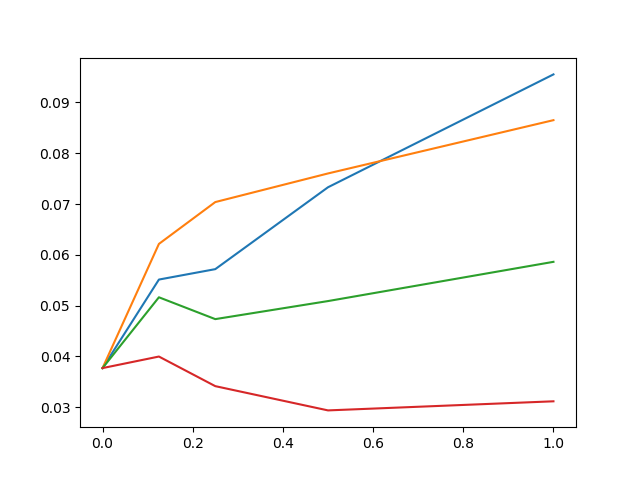

In [137]:
plt.figure()
plt.plot(np.append((0,),ucontrast),np.concatenate((np.tile(pct0[lkat].mean(),(4,1)),mn_lkat),axis=1).T)

In [74]:
matdict = {}
matdict['dataX'] = Savg[lkat][:,1,0]
matdict['dataY'] = Savg[lkat][:,-1,0]
matdict['dataZ'] = Savg[lkat][:,1,-1]
matdict['dataW'] = Savg[lkat][:,-1,-1]
matdict['leg'] = ['12%','100%']
# matdict['data'] = mn_lkat
matdict['labelX'] = 'mean event rate, 15 deg.'
matdict['labelY'] = 'mean event rate, 60 deg.'
# matdict['x'] = 100*ucontrast
sio.savemat('size_scatter_lc_hc.mat',matdict)

In [82]:
matdict = {}
matdict['dataX'] = Savg[lkat][:,-1,0]/Savg[lkat][:,:,0].max(1)
matdict['dataY'] = Savg[lkat][:,-1,-1]/Savg[lkat][:,:,-1].max(1)
# matdict['leg'] = ['12%','100%']
# matdict['data'] = mn_lkat
matdict['labelX'] = 'surround suppression index, 12% contrast'
matdict['labelY'] = 'surround suppression index, 100% contrast'
# matdict['x'] = 100*ucontrast
sio.savemat('size_scatter_si_lc_hc.mat',matdict)

In [83]:
matdict = {} #sio.loadmat('lc_hc_60deg.mat')
matdict['dataX'] = Savg[lkat][:,-1,0]/Savg[lkat].max(1).max(1)
matdict['dataY'] = Savg[lkat][:,-1,-1]/Savg[lkat].max(1).max(1)
# matdict['leg'] = ['12%','100%']
# matdict['data'] = mn_lkat
matdict['labelX'] = 'norm. event rate, 12% contrast'
matdict['labelY'] = 'norm. event rate, 100% contrast'
# matdict['x'] = 100*ucontrast
sio.savemat('lc_hc_60deg.mat',matdict)

<IPython.core.display.Javascript object>


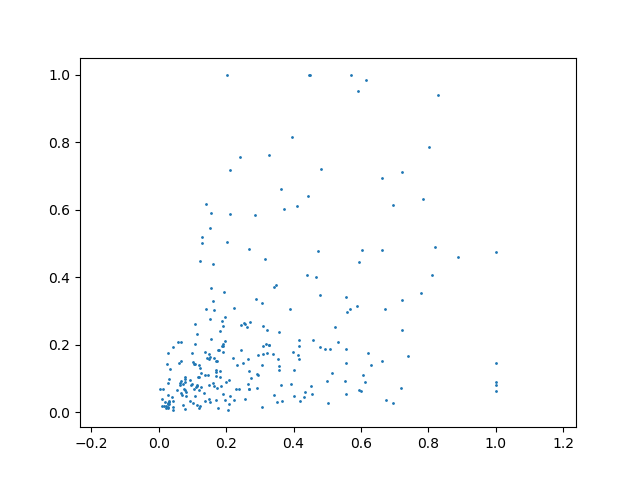

(-0.046404911568387365,
 1.050884872901106,
 -0.044602802817010616,
 1.0511602241704248)

In [80]:
plt.figure()
plt.scatter(Savg[lkat][:,-1,0]/Savg[lkat].max(1).max(1),Savg[lkat][:,-1,-1]/Savg[lkat].max(1).max(1),s=1)
plt.axis('equal')

<IPython.core.display.Javascript object>


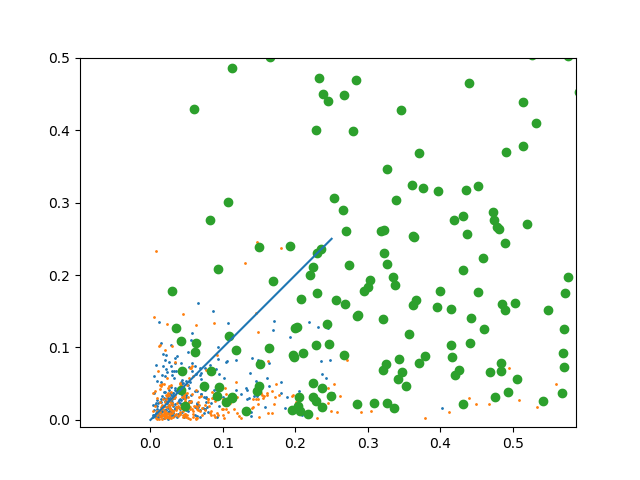

(-0.01, 0.5)

In [68]:
plt.figure()
bd = ((-0.01,0.5))
plt.scatter(Savg[lkat][:,1,0],Savg[lkat][:,-1,0],s=1)
plt.scatter(Savg[lkat][:,1,-1],Savg[lkat][:,-1,-1],s=1)
plt.plot((0,0.25),(0,0.25))
plt.axis('equal')
plt.xlim(bd)
plt.ylim(bd)

<IPython.core.display.Javascript object>


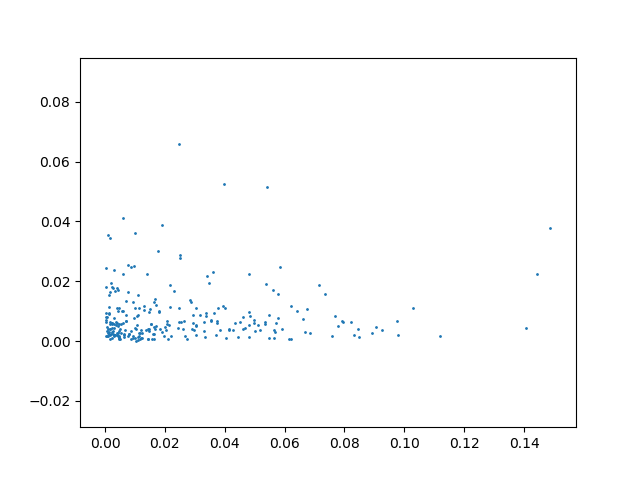

In [147]:
plt.figure()
mx = np.nanmax(np.nanmax(strialwise,axis=1),axis=1)
plt.scatter(Savg[lkat][:,0,-1]/mx[lkat],Savg[lkat][:,-1,-1]/mx[lkat],s=1)
plt.axis('equal')

matdict = {}
matdict['dataX'] = Savg[lkat][:,0,-1]/mx[lkat]
matdict['dataY'] = Savg[lkat][:,-1,-1]/mx[lkat]
matdict['labelX'] = 'norm. event rate, 15 deg'
matdict['labelY'] = 'norm. event rate, 60 deg'
sio.savemat('pc_figure_iso.mat',matdict)

In [90]:
_,pval = sst.ttest_ind(Storiavg[:,1,-1].T,Storiavg[:,1,0].T)

In [91]:
Storiavg[:,1,-1].shape

(1116, 5)

In [98]:
Storiavg.shape

(1116, 4, 4, 5)

In [94]:
usize

array([  7.5,  15. ,  30. ,  60. ])

<IPython.core.display.Javascript object>


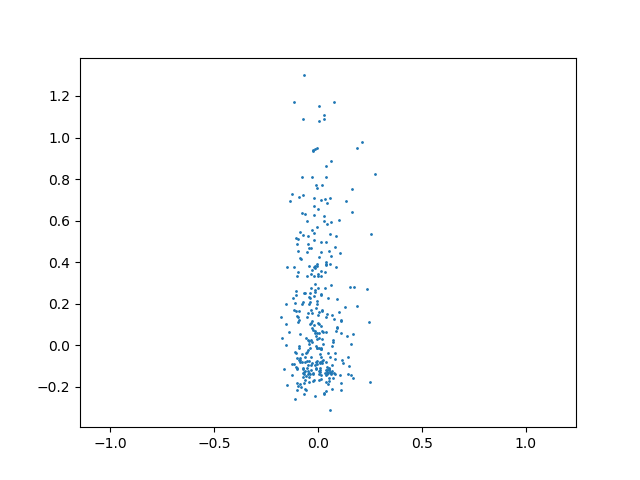

(-0.20048138309467967,
 0.29651950939117927,
 -0.39537268296835099,
 1.3849056596686917)

In [100]:
plt.figure()
# mx = np.nanmax(np.nanmax(strialwise,axis=1),axis=1)
_,pval = sst.ttest_ind(Storiavg[:,1,-1].T,Storiavg[:,1,0].T)
sig = pval<0.05
plt.scatter(pct0[sig],Savg[sig][:,1,-1],s=1)

matdict = sio.loadmat('vip_pc_zero_100_contrast_15deg.mat',squeeze_me=True)
matdict['dataX'] = pct0[sig]#/mx[lkat]
matdict['dataY'] = Savg[sig][:,1,-1]#/mx[lkat]
sio.savemat('vip_pc_zero_100_contrast_15deg.mat',matdict)

plt.axis('equal')

In [131]:
(Savg[lkat][:,0,-1]/mx[lkat]).shape

(265, 1, 265)

In [135]:
(Savg[lkat][:,0,-1]/mx[lkat]).shape

(265, 1, 265)

<IPython.core.display.Javascript object>


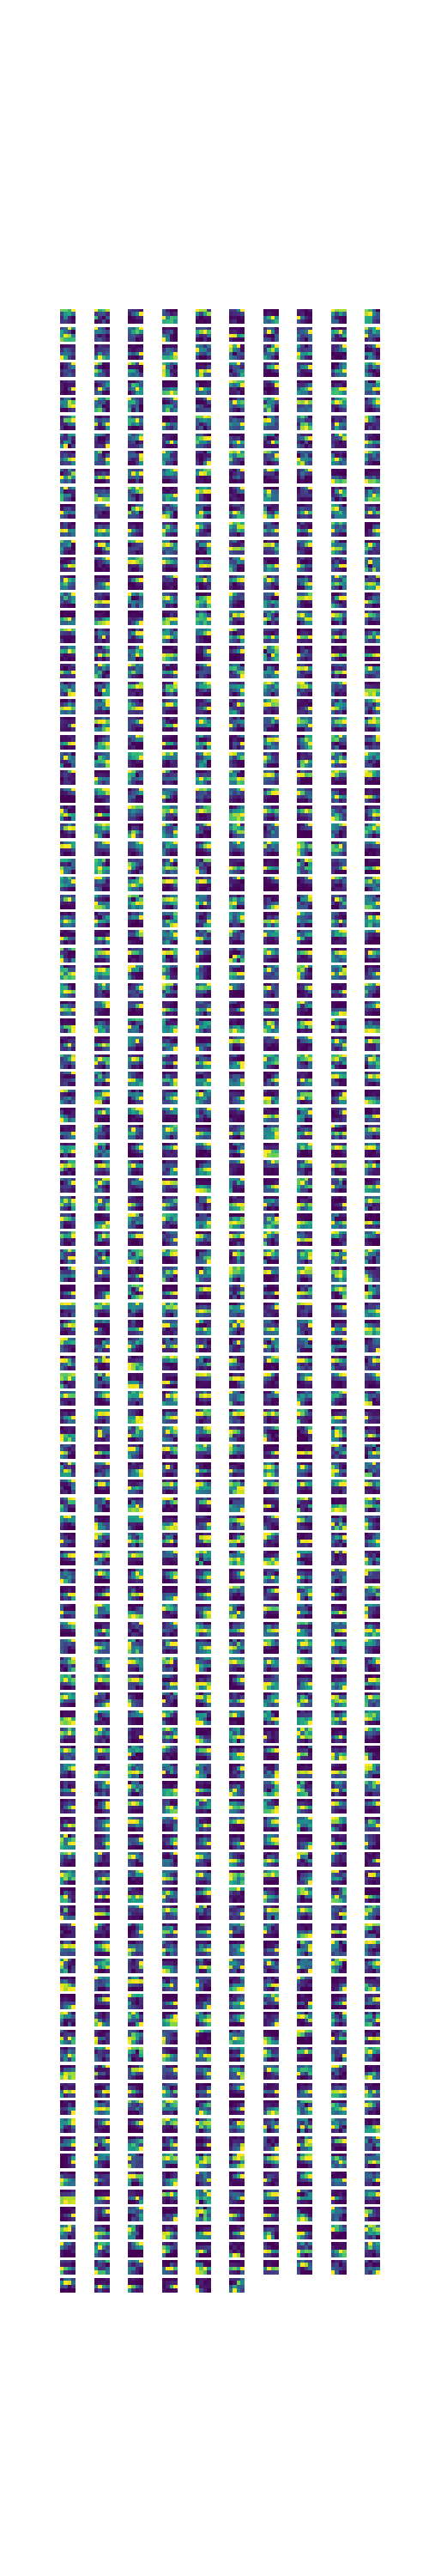

In [42]:
plt.figure(figsize=(5,30))
for i in range(Savg.shape[0]):
    plt.subplot(112,10,i+1)
    plt.imshow(Savg[i])
    plt.axis('off')

In [93]:
pct0[lkat]

(1116,)

<IPython.core.display.Javascript object>


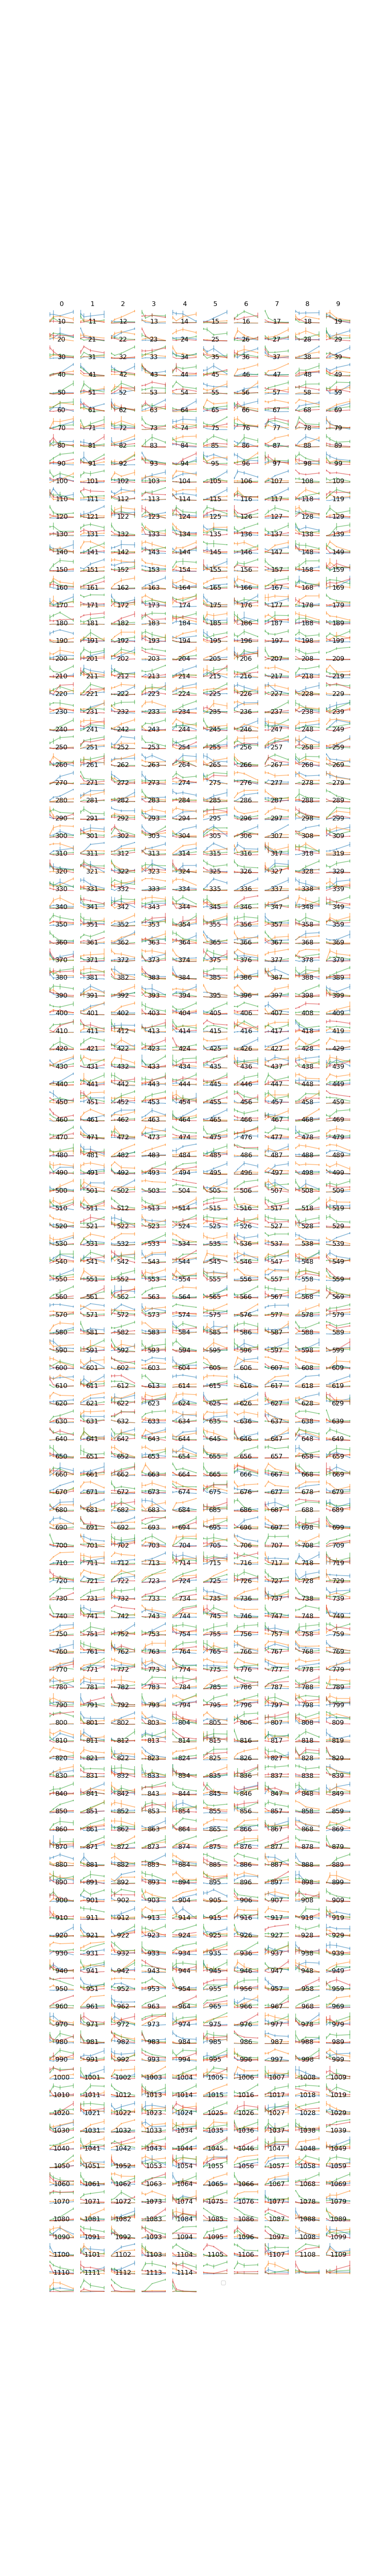

(0.0, 1.0, 0.0, 1.0)

In [179]:
plt.figure(figsize=(10,66))
errorplus = ub-Savg
errorminus = Savg-lb
errors = np.concatenate((errorplus[np.newaxis],errorminus[np.newaxis]),axis=0)
for k in range(Savg.shape[0]-1):
#     plt.subplot(112,10,k+1)
    plt.subplot(112,10,k+1)
    plt.title(k)
#     plt.plot(ucontrast,Savg[k])
    for i in range(lb.shape[1]):
        plt.errorbar(ucontrast,Savg[k,i,:],yerr=errors[:,k,i,:],alpha=0.5)
#     plt.legend([int(np.round(x)) for x in usize])
    plt.axis('off')
plt.subplot(112,10,Savg.shape[0])
plt.legend([int(round(x)) for x in usize])
plt.axis('off')

In [36]:
plt.figure(figsize=(10,66))
errorplus = ub-Savg
errorminus = Savg-lb
errors = np.concatenate((errorplus[np.newaxis],errorminus[np.newaxis]),axis=0)
for k in range(Savg.shape[0]-1):
#     plt.subplot(112,10,k+1)
    plt.subplot(112,10,k+1)
    plt.title(k)
#     plt.plot(ucontrast,Savg[k])
    for i in range(lb.shape[1]):
        plt.errorbar(usize,Savg[k,:,i],yerr=errors[:,k,:,i],alpha=0.5)
#     plt.legend([int(np.round(x)) for x in usize])
    plt.axis('off')
plt.subplot(112,10,Savg.shape[0])
plt.legend([int(round(x)) for x in usize])
plt.axis('off')

<IPython.core.display.Javascript object>

(0.0, 1.0, 0.0, 1.0)

<IPython.core.display.Javascript object>


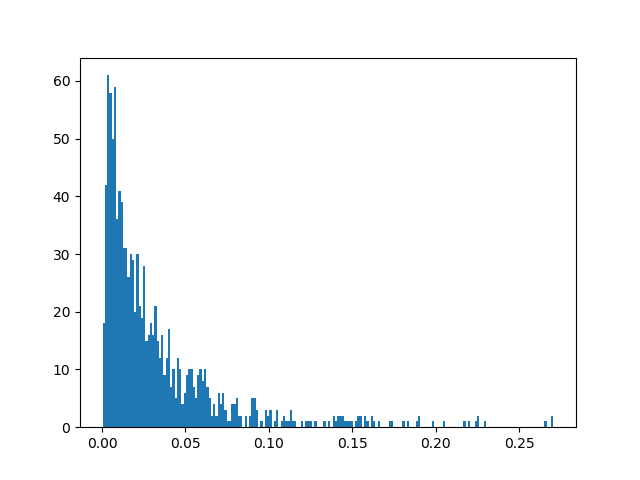

In [123]:
plt.figure()
plt.hist(lb[:,0].mean(-1),bins=200)
above_thresh = lb[:,0].mean(-1)>0.05

<IPython.core.display.Javascript object>


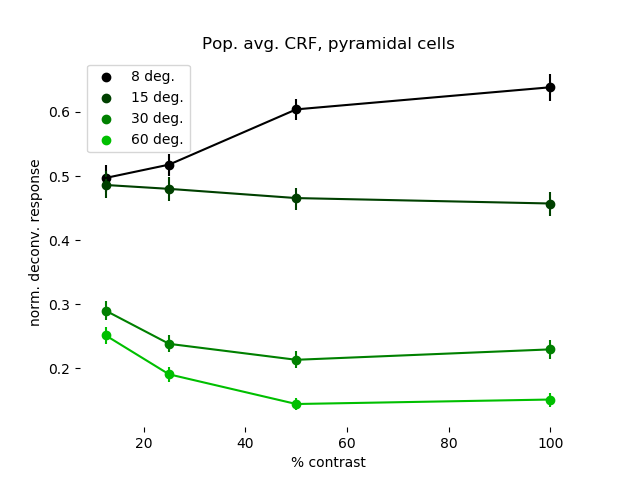

In [135]:
plt.figure()
colors = [np.array((0,1,0))*i/len(ucontrast) for i in range(len(usize))]
Savgnorm = Savg/Savg.max(-1).max(-1)[:,np.newaxis,np.newaxis]
lb_target,ub_target = ut.bootstrap(Savgnorm[above_thresh],np.nanmean,axis=0,pct=(16,84))
Savg_target = np.nanmean(Savgnorm[above_thresh],axis=0)
errorplus = ub_target-Savg_target
errorminus = Savg_target-lb_target
errors = np.concatenate((errorplus[np.newaxis],errorminus[np.newaxis]),axis=0)
for i in range(lb.shape[1]):
    plt.errorbar(100*ucontrast,Savg_target[i,:],yerr=errors[:,i,:],c=colors[i])
    plt.scatter(100*ucontrast,Savg_target[i,:],c=colors[i])
plt.legend([str(int(round(x)))+' deg.' for x in usize])
plt.box(None)
plt.title('Pop. avg. CRF, pyramidal cells')
plt.xlabel('% contrast')
plt.ylabel('norm. deconv. response')
plt.savefig('pc_pop_avg.eps')

<IPython.core.display.Javascript object>


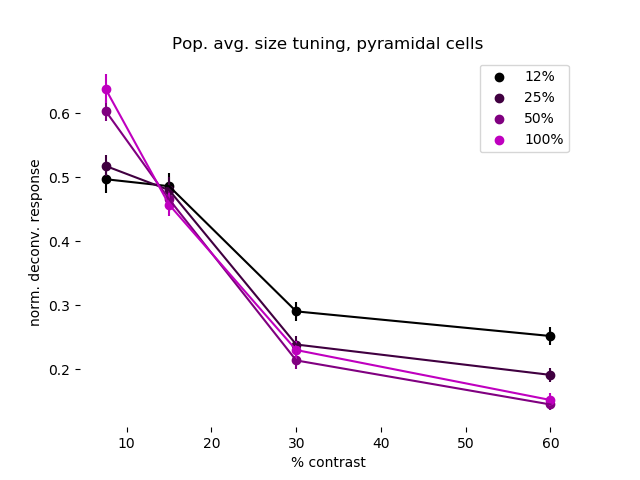

In [134]:
plt.figure()
colors = [np.array((1,0,1))*i/len(ucontrast) for i in range(len(usize))]
Savgnorm = Savg/Savg.max(-1).max(-1)[:,np.newaxis,np.newaxis]
lb_target,ub_target = ut.bootstrap(Savgnorm[above_thresh],np.nanmean,axis=0,pct=(16,84))
Savg_target = np.nanmean(Savgnorm[above_thresh],axis=0)
errorplus = ub_target-Savg_target
errorminus = Savg_target-lb_target
errors = np.concatenate((errorplus[np.newaxis],errorminus[np.newaxis]),axis=0)
for i in range(lb.shape[1]):
    plt.errorbar(usize,Savg_target[:,i],yerr=errors[:,:,i],c=colors[i])
    plt.scatter(usize,Savg_target[:,i],c=colors[i])
plt.legend([str(int(round(100*x)))+'%' for x in ucontrast])
plt.box(None)
plt.title('Pop. avg. size tuning, pyramidal cells')
plt.xlabel('% contrast')
plt.ylabel('norm. deconv. response')
plt.savefig('pc_pop_avg_size_tuning.eps')

In [92]:
[int(round(x)) for x in usize]

[8, 15, 30, 60]

In [186]:
(errors[:,ind,i,:]/Savg[ind].max()).shape

(2, 4)

<IPython.core.display.Javascript object>


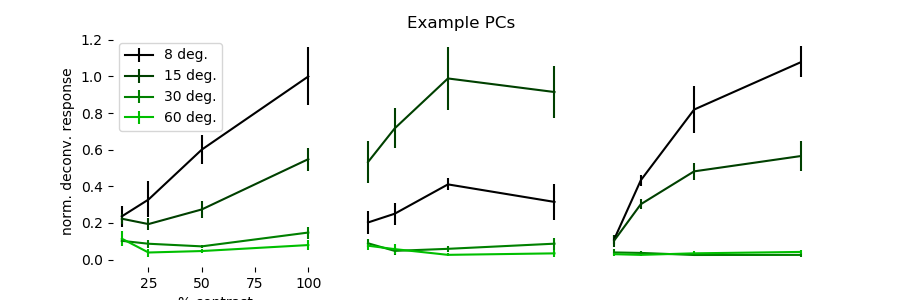

/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [192]:
plt.figure(figsize=(9,3),frameon=False)
facilitated_list = [609,855,1092]
colors = [np.array((0,1,0))*i/len(ucontrast) for i in range(len(usize))]
for j,ind in enumerate(facilitated_list):
    plt.subplot(1,3,j+1)
    for i in range(lb.shape[1]):
        plt.errorbar(100*ucontrast,Savg[ind,i,:]/Savg[ind].max(),yerr=errors[:,ind,i,:]/Savg[ind].max(),c=colors[i])
    plt.axis('off')
plt.subplot(1,3,1)
plt.axis('on')
plt.xlabel('% contrast')
plt.ylabel('norm. deconv. response')
plt.box(on=None)
plt.subplot(1,3,1)
plt.legend([str(int(round(x)))+' deg.' for x in usize],loc='upper left')
plt.subplot(1,3,2)
plt.title('Example PCs')
plt.savefig('pc_crf.eps')

<IPython.core.display.Javascript object>


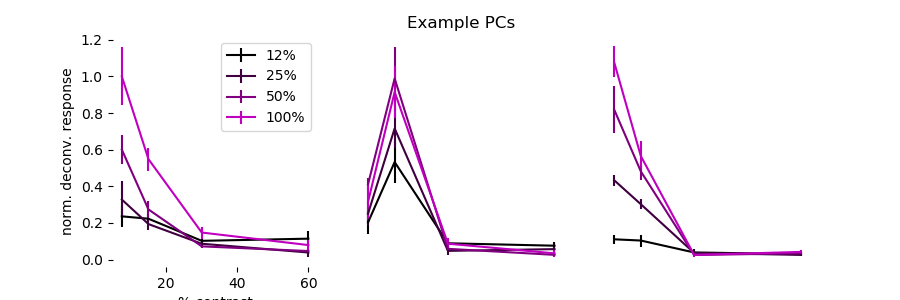

/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [191]:
plt.figure(figsize=(9,3),frameon=False)
facilitated_list = [609,855,1092]
colors = [np.array((1,0,1))*i/len(ucontrast) for i in range(len(usize))]
for j,ind in enumerate(facilitated_list):
    plt.subplot(1,3,j+1)
    for i in range(lb.shape[1]):
        plt.errorbar(usize,Savg[ind,:,i]/Savg[ind].max(),yerr=errors[:,ind,:,i]/Savg[ind].max(),c=colors[i])
    plt.axis('off')
plt.subplot(1,3,1)
plt.axis('on')
plt.xlabel('% contrast')
plt.ylabel('norm. deconv. response')
plt.box(on=None)
plt.subplot(1,3,1)
plt.legend([str(int(round(100*x)))+'%' for x in ucontrast],loc='upper right')
plt.subplot(1,3,2)
plt.title('Example PCs')
plt.savefig('pc_size_tuning.eps')

In [374]:
sorting = np.argsort(pval.min(0))
sorting

array([ 303,  775,  417, ...,  815,  747, 1115])

In [375]:
(pval.min(0)<0.05).sum()

/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


332

In [267]:
# ontarget = np.logical_and(Savg[:,0,0]<Savg[:,1,0],np.logical_and(Savg[:,1,0]<Savg[:,2,0],Savg[:,2,0]<Savg[:,3,0]))

In [376]:
ontarget = np.logical_and(np.diff(Savg[:,:,0],axis=1).min(1)>0,pval.min(0)<0.05)

/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [377]:
ontarget.sum()

95

<IPython.core.display.Javascript object>


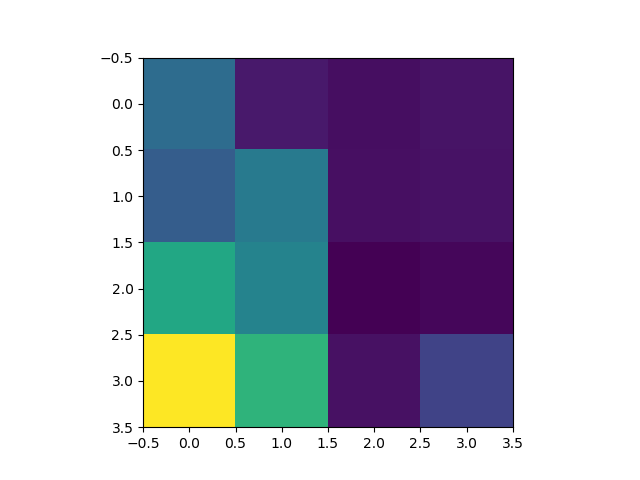

In [378]:
plt.imshow(Savg[417])

<IPython.core.display.Javascript object>


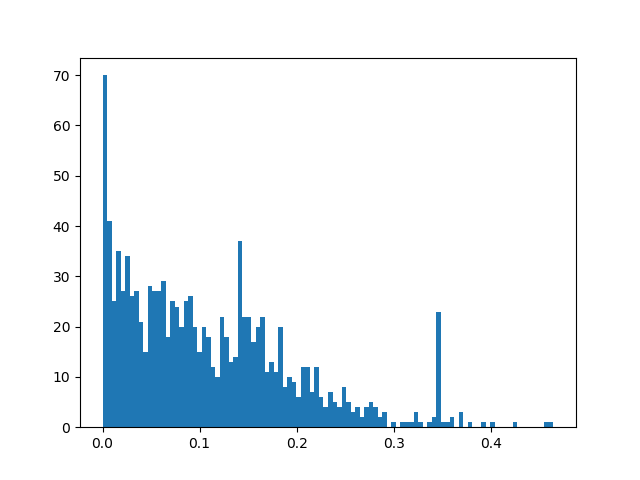

(array([ 70.,  41.,  25.,  35.,  27.,  34.,  26.,  27.,  21.,  15.,  28.,
         27.,  27.,  29.,  18.,  25.,  24.,  20.,  25.,  26.,  20.,  15.,
         20.,  18.,  12.,  10.,  22.,  18.,  13.,  14.,  37.,  22.,  22.,
         17.,  20.,  22.,  11.,  13.,  11.,  20.,   8.,  10.,   9.,   6.,
         12.,  12.,   7.,  12.,   6.,   4.,   7.,   5.,   4.,   8.,   5.,
          3.,   4.,   2.,   4.,   5.,   4.,   2.,   3.,   0.,   1.,   0.,
          1.,   1.,   1.,   3.,   1.,   0.,   1.,   2.,  23.,   1.,   1.,
          2.,   0.,   3.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.]), array([  1.05554141e-05,   4.65693275e-03,   9.30331009e-03,
          1.39496874e-02,   1.85960648e-02,   2.32424421e-02,
          2.78888195e-02,   3.25351968e-02,   3.71815741e-02,
          4.18279515e-02,   4.64743288e-02,   5.11207061e-02,
          5.57670835e-02,   6.04134608e-02,   6.50598382e-02,
         

In [379]:
plt.hist(np.nanmin(pval,axis=0),bins=100)

<IPython.core.display.Javascript object>


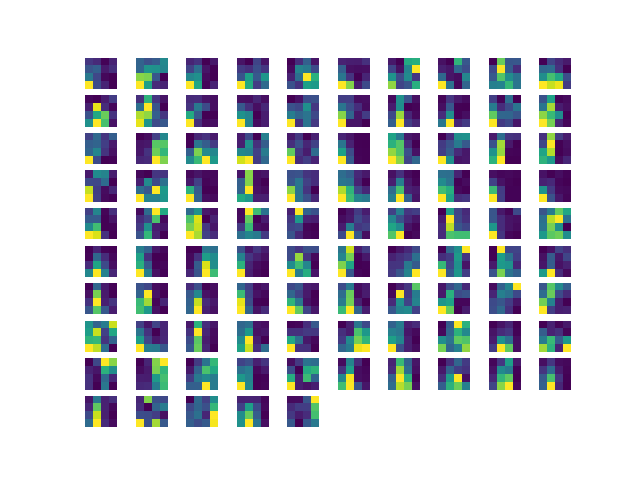

In [380]:
for i in range(95):
    plt.subplot(10,10,i+1)
    plt.imshow(Savg[ontarget][i])
    plt.axis('off')

In [398]:
ontarget.sum()

95

<IPython.core.display.Javascript object>


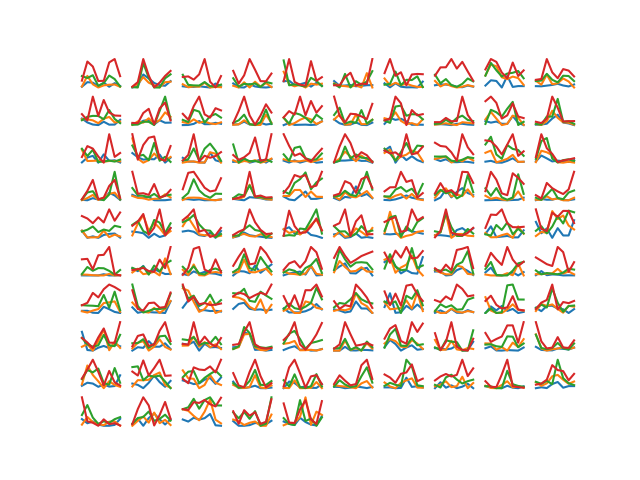

In [400]:
for i in range(ontarget.sum()):
    plt.subplot(10,10,i+1)
    for k in range(4):
        plt.plot(Stavg[ontarget][i,:,k,0].mean(-1))
    plt.axis('off')

In [551]:
Stavg[ontarget][thisind,:,:,0].shape
lb,ub = ut.bootstrap(Stavg[ontarget][thisind,:,:,0],np.mean,pct=(16,84),axis=2)
mn,_ = ut.bootstrap(Stavg[ontarget][thisind,:,:,0],np.mean,pct=(50,50),axis=2)
lb.shape

(8, 4)

<IPython.core.display.Javascript object>


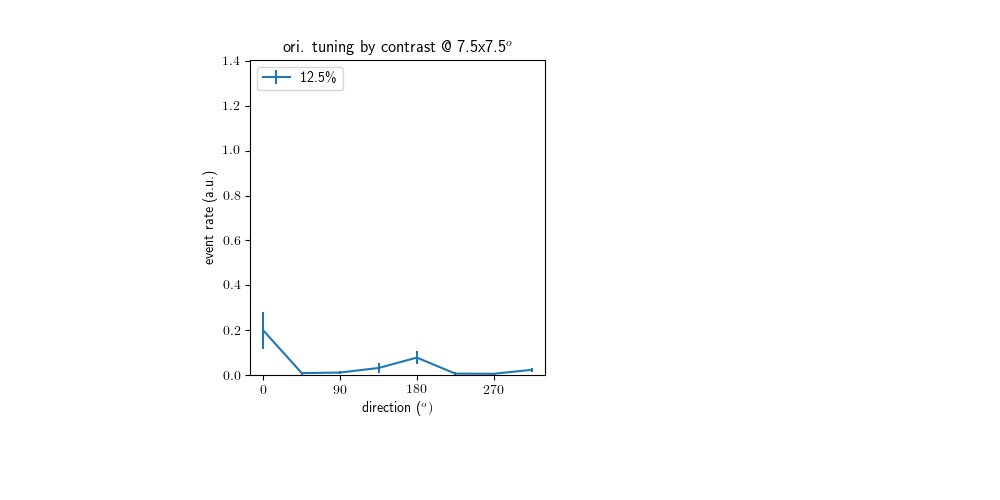

<IPython.core.display.Javascript object>


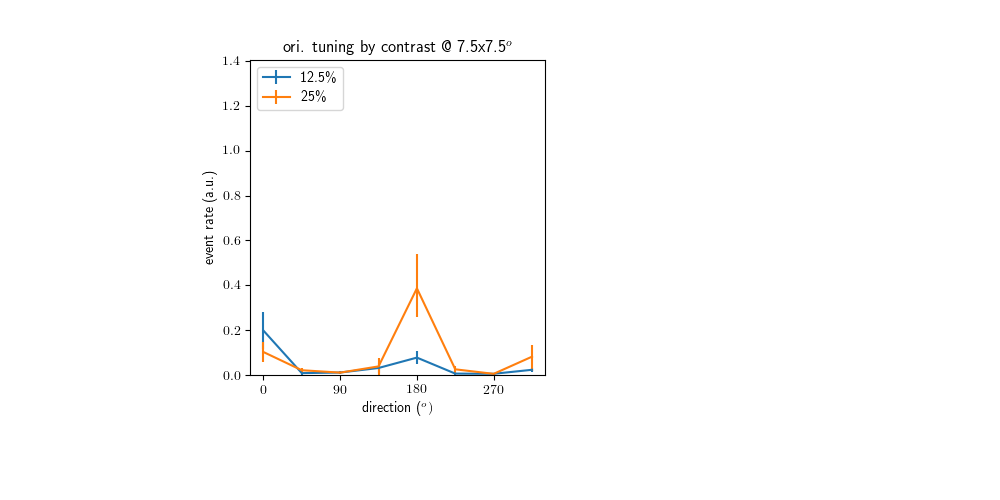

<IPython.core.display.Javascript object>


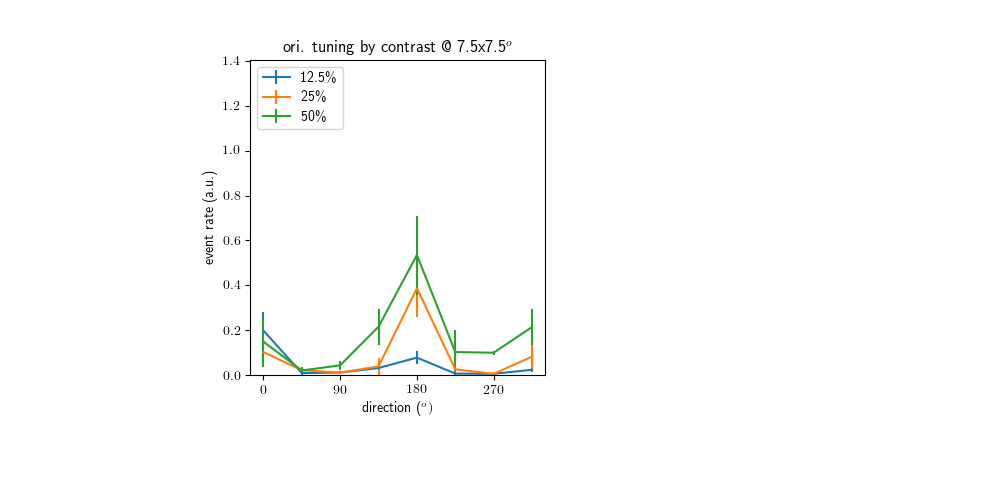

<IPython.core.display.Javascript object>


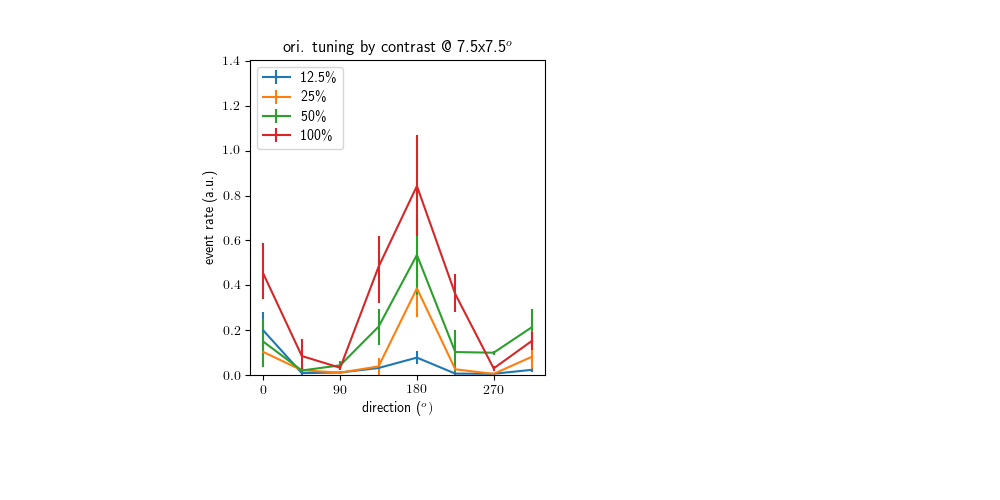

In [558]:
thisind = 83
lb,ub = ut.bootstrap(Stavg[ontarget][thisind,:,:,0],np.mean,pct=(16,84),axis=2)
mn,_ = ut.bootstrap(Stavg[ontarget][thisind,:,:,0],np.mean,pct=(50,50),axis=2)
rc('text', usetex=True)
for j in range(4):
#     plt.subplot(4,1,j+1)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title(r'ori. tuning by contrast @ 7.5x7.5^o')
    for i in range(j+1):
        yerr = np.concatenate((ub[:,i:i+1].T-mn[:,i:i+1].T,mn[:,i:i+1].T-lb[:,i:i+1].T),axis=0)
        plt.errorbar(np.arange(0,360,45),mn[:,i],yerr=yerr)
#         plt.errorbar(np.arange(0,360,45),Stavg[ontarget][thisind,:,k,0].mean(-1),Stavg[ontarget][thisind,:,k,0].std(-1)/np.sqrt(5))
        plt.ylim(0,Stavg[ontarget][thisind].max())
        plt.xticks((0,90,180,270))
        plt.xlabel('direction (^o)')
        plt.ylabel('event rate (a.u.)')
    plt.legend([r'12.5\%',r'25\%',r'50\%',r'100\%'],loc='upper left')    
#     plt.subplot(4,1,1)
    plt.gcf().subplots_adjust(bottom=0.25,left=0.25)
    pylab.savefig('/home/mossing/excitation/thesis_mtg_18/contrast'+str(j)+'.png')

In [566]:
Stavg[ontarget][thisind,:,3,:].shape

(8, 4, 5)

<IPython.core.display.Javascript object>


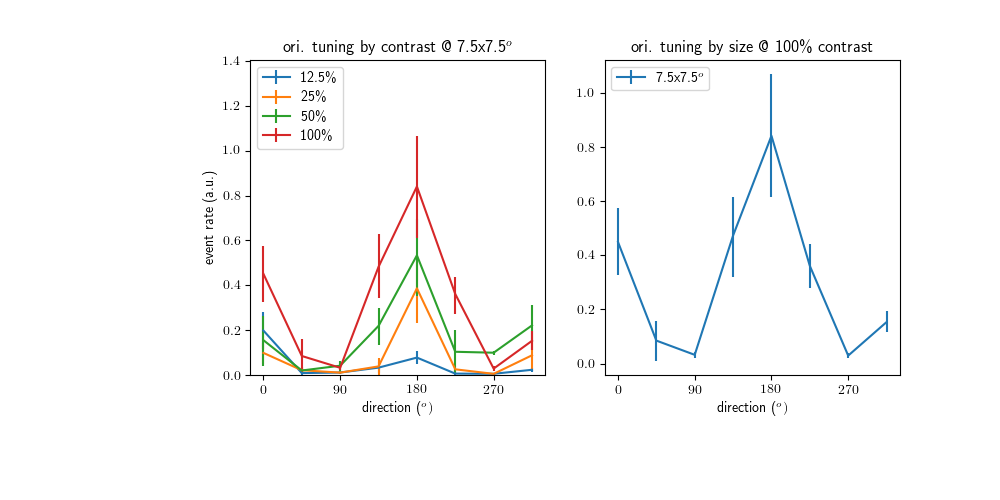

<IPython.core.display.Javascript object>


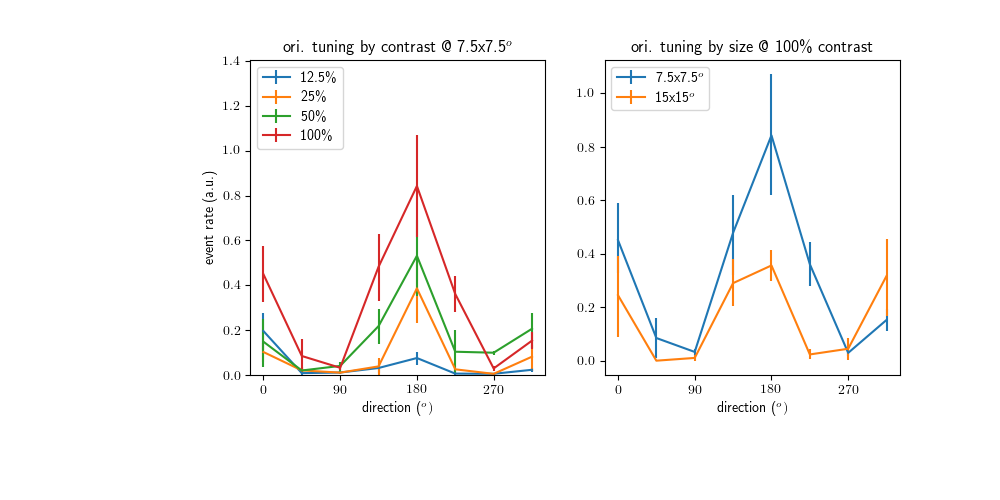

<IPython.core.display.Javascript object>


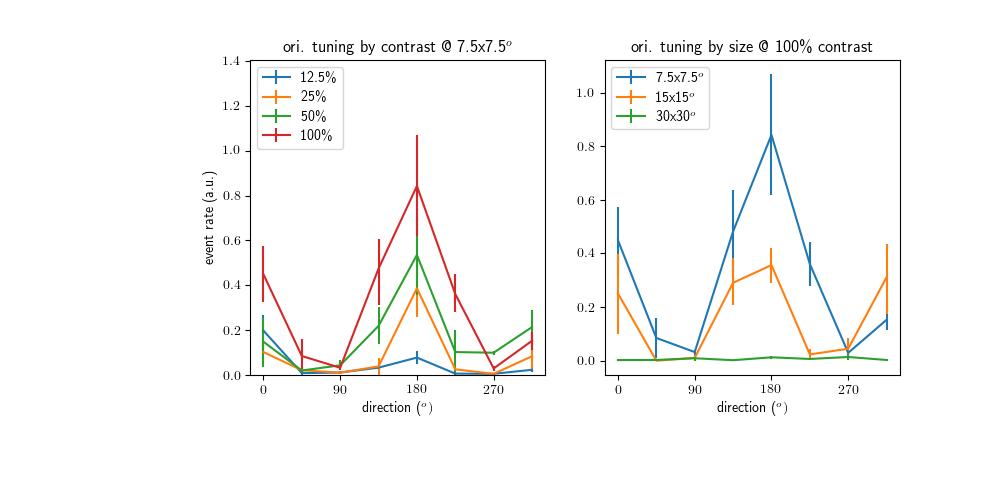

<IPython.core.display.Javascript object>


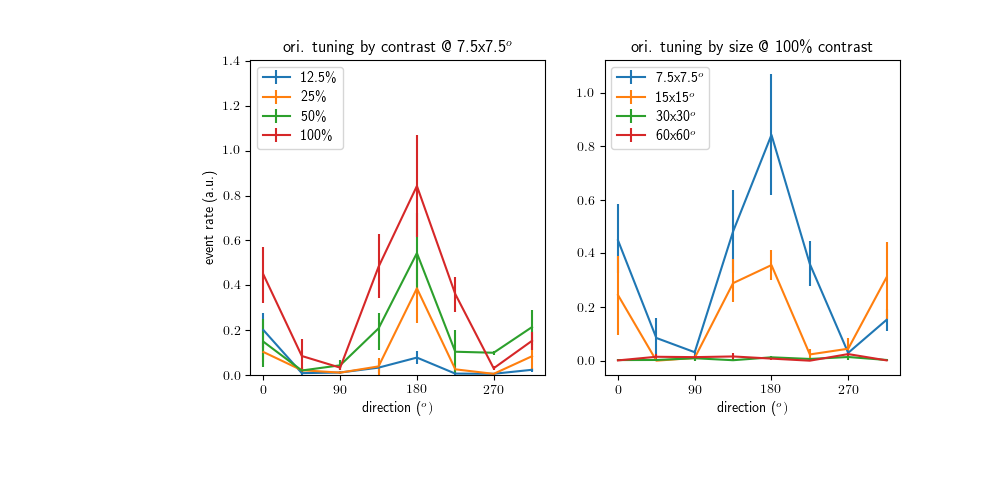

In [572]:
thisind = 83
rc('text', usetex=True)
for j in range(4):
    lb,ub = ut.bootstrap(Stavg[ontarget][thisind,:,:,0],np.mean,pct=(16,84),axis=2)
    mn,_ = ut.bootstrap(Stavg[ontarget][thisind,:,:,0],np.mean,pct=(50,50),axis=2)
#     plt.subplot(4,1,j+1)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title(r'ori. tuning by contrast @ 7.5x7.5^o')
    for i in range(4):
        yerr = np.concatenate((ub[:,i:i+1].T-mn[:,i:i+1].T,mn[:,i:i+1].T-lb[:,i:i+1].T),axis=0)
        plt.errorbar(np.arange(0,360,45),mn[:,i],yerr=yerr)
#         plt.errorbar(np.arange(0,360,45),Stavg[ontarget][thisind,:,k,0].mean(-1),Stavg[ontarget][thisind,:,k,0].std(-1)/np.sqrt(5))
        plt.ylim(0,Stavg[ontarget][thisind].max())
        plt.xticks((0,90,180,270))
        plt.xlabel('direction (^o)')
        plt.ylabel('event rate (a.u.)')
    plt.legend([r'12.5\%',r'25\%',r'50\%',r'100\%'],loc='upper left')    
#     plt.subplot(4,1,1)
    plt.gcf().subplots_adjust(bottom=0.25,left=0.25)
#     pylab.savefig('/home/mossing/excitation/thesis_mtg_18/contrast'+str(j)+'.png')
    plt.subplot(1,2,2)
    lb,ub = ut.bootstrap(Stavg[ontarget][thisind,:,3,:],np.mean,pct=(16,84),axis=2)
    mn,_ = ut.bootstrap(Stavg[ontarget][thisind,:,3,:],np.mean,pct=(50,50),axis=2)
    for i in range(j+1):
        plt.title(r'ori. tuning by size @ 100\% contrast')
        yerr = np.concatenate((ub[:,i:i+1].T-mn[:,i:i+1].T,mn[:,i:i+1].T-lb[:,i:i+1].T),axis=0)
        plt.errorbar(np.arange(0,360,45),mn[:,i],yerr=yerr)
        plt.xticks((0,90,180,270))
        plt.xlabel('direction (^o)')
#         plt.ylabel('event rate (a.u.)')
    plt.legend([r'7.5x7.5^o',r'15x15^o',r'30x30^o',r'60x60^o'],loc='upper left')    
        #     plt.subplot(4,1,1)
    plt.gcf().subplots_adjust(bottom=0.25,left=0.25)
    pylab.savefig('/home/mossing/excitation/thesis_mtg_18/size'+str(j)+'.png')

<IPython.core.display.Javascript object>


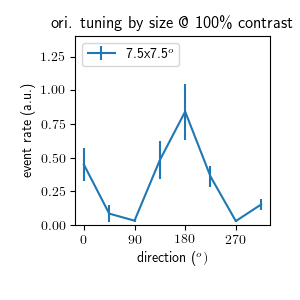

<IPython.core.display.Javascript object>


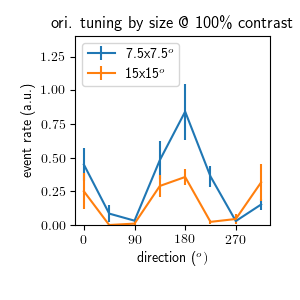

<IPython.core.display.Javascript object>


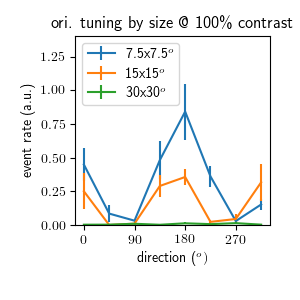

<IPython.core.display.Javascript object>


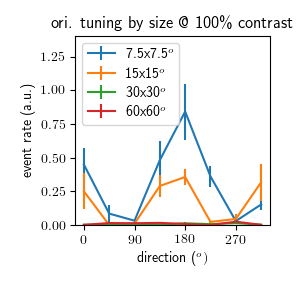

In [478]:
rc('text', usetex=True)
for j in range(4):
#     plt.subplot(4,1,j+1)
    plt.figure(figsize=(5,5))
    plt.title(r'ori. tuning by size @ 100\% contrast')
    for k in range(j+1):
        plt.errorbar(np.arange(0,360,45),Stavg[ontarget][thisind,:,3,k].mean(-1),Stavg[ontarget][thisind,:,3,k].std(-1)/np.sqrt(5))
        plt.ylim(0,Stavg[ontarget][thisind].max())
        plt.xticks((0,90,180,270))
        plt.xlabel('direction (^o)')
        plt.ylabel('event rate (a.u.)')
    plt.legend([r'7.5x7.5^o',r'15x15^o',r'30x30^o',r'60x60^o'],loc='upper left')    
#     plt.subplot(4,1,1)
    plt.gcf().subplots_adjust(bottom=0.25,left=0.25)

In [561]:
Stavg[ontarget][thisind,:,3,:].shape

(8, 4, 5)

In [466]:
Stavg[ontarget][thisind].mean(0).mean(-1).shape

(4, 4)

<IPython.core.display.Javascript object>


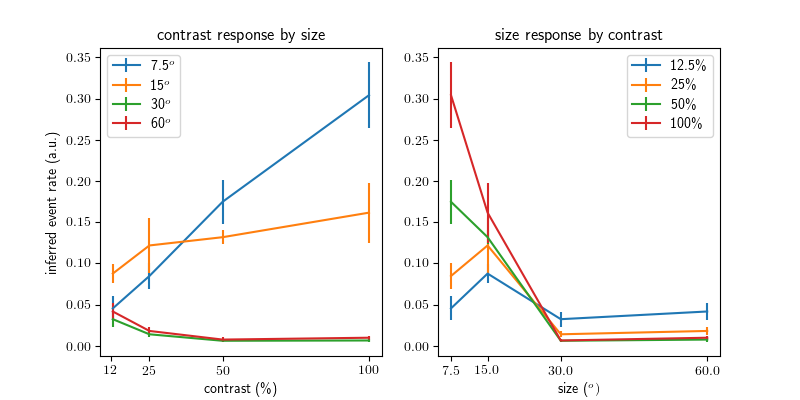

([<matplotlib.axis.XTick at 0x7fe2eeca1f98>,
 <a list of 4 Text xticklabel objects>)

In [469]:
thisind = 83
plt.figure(figsize=(8,4))
plt.subplot(1,2,2)
plt.title('size response by contrast')
for i in range(Savg.shape[1]):
    plt.errorbar(usize,Stavg[ontarget][thisind].mean(0).mean(-1).T[:,i],yerr=Stavg[ontarget][thisind].mean(0).std(-1).T[:,i]/np.sqrt(5))
plt.legend([r'12.5\%',r'25\%',r'50\%',r'100\%'])
plt.xlabel(r'size (^o)')
locs, labels = plt.xticks()
plt.xticks(usize)
plt.subplot(1,2,1)
plt.title('contrast response by size')
for i in range(Savg.shape[2]):
    plt.errorbar(100*ucontrast,Stavg[ontarget][thisind].mean(0).mean(-1)[:,i],yerr=Stavg[ontarget][thisind].mean(0).std(-1)[:,i]/np.sqrt(5))
plt.legend([r'7.5^o',r'15^o',r'30^o',r'60^o'])
plt.xlabel(r'contrast (\%)')
# plt.ylabel('inferred event rate (a.u.)')
locs, labels = plt.xticks()
plt.ylabel('inferred event rate (a.u.)')
plt.xticks((100*ucontrast).astype(np.uint16))

<IPython.core.display.Javascript object>


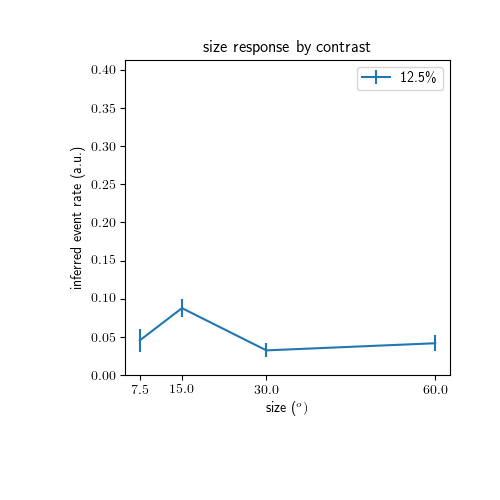

<IPython.core.display.Javascript object>


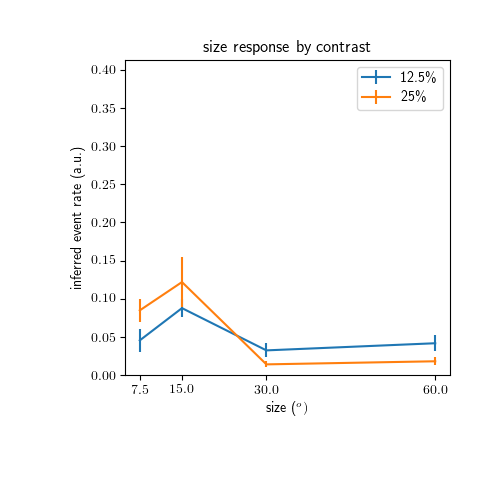

<IPython.core.display.Javascript object>


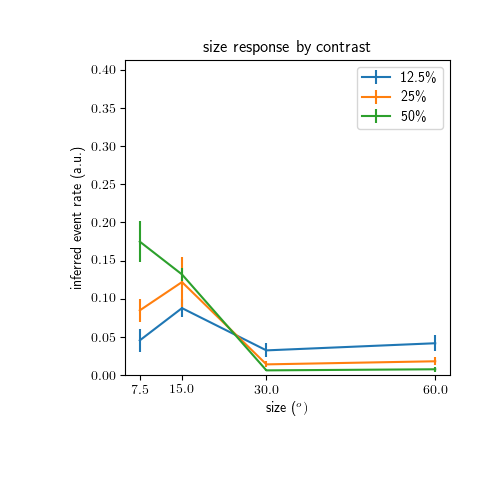

<IPython.core.display.Javascript object>


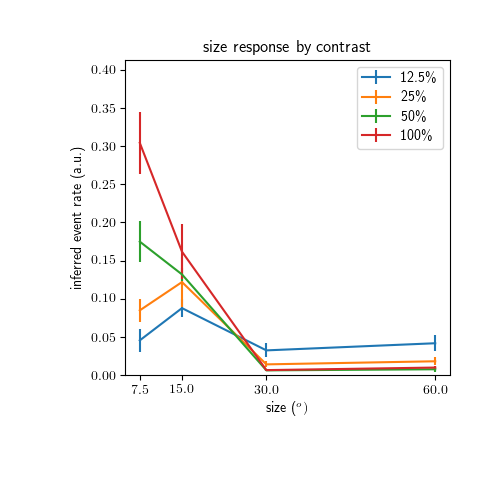

In [525]:
thisind = 83
for j in range(Savg.shape[1]):
    plt.figure(figsize=(5,5))
    plt.title('size response by contrast')
    for i in range(j+1):
        plt.errorbar(usize,Stavg[ontarget][thisind].mean(0).mean(-1).T[:,i],yerr=Stavg[ontarget][thisind].mean(0).std(-1).T[:,i]/np.sqrt(5))
    plt.legend([r'12.5\%',r'25\%',r'50\%',r'100\%'])
    plt.xlabel(r'size (^o)')
    plt.ylabel(r'inferred event rate (a.u.)')
    plt.ylim(Stavg[ontarget][thisind].mean(0).min(),Stavg[ontarget][thisind].mean(0).max())
    locs, labels = plt.xticks()
    plt.xticks(usize)
    plt.gcf().subplots_adjust(bottom=0.25,left=0.25)

In [530]:
Stavg[ontarget][thisind].mean(0).shape

(4, 4, 5)

In [543]:
pwd

'/home/mossing/Documents/notebooks/size_contrast'

<IPython.core.display.Javascript object>


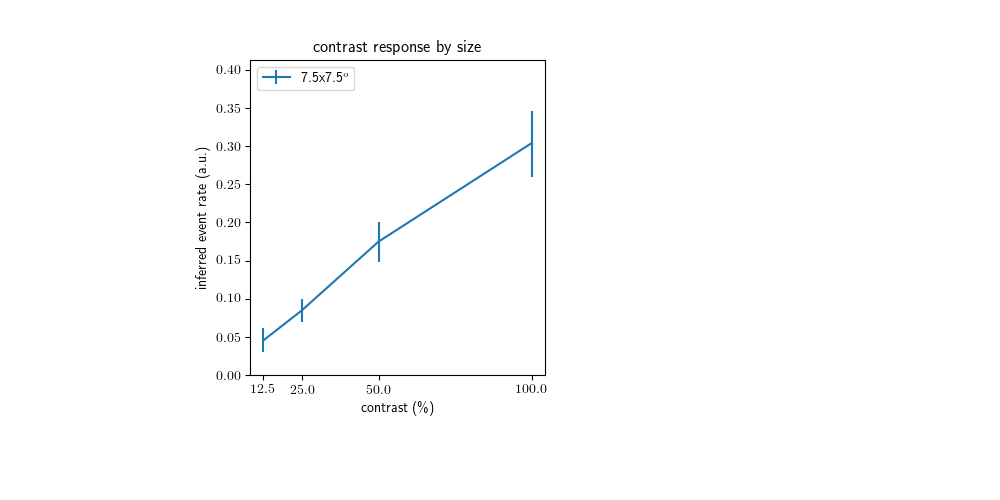

/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<IPython.core.display.Javascript object>


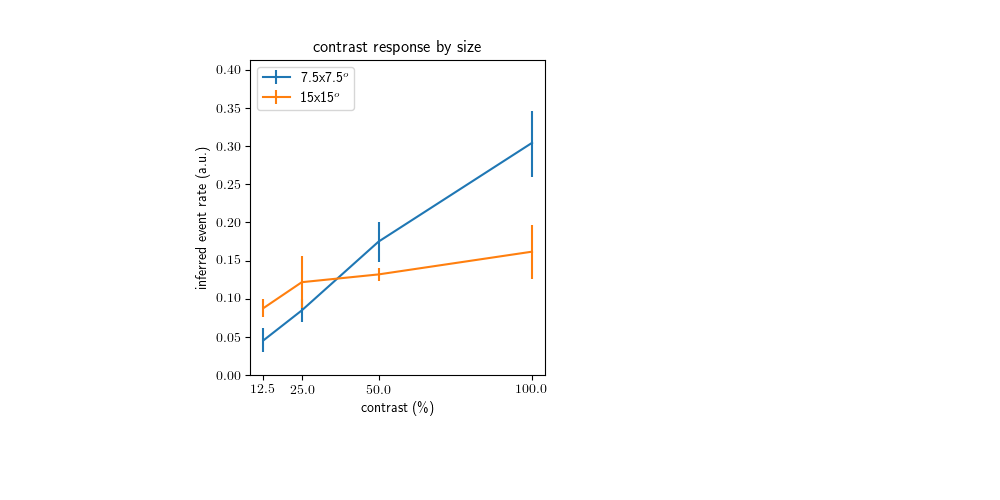

<IPython.core.display.Javascript object>


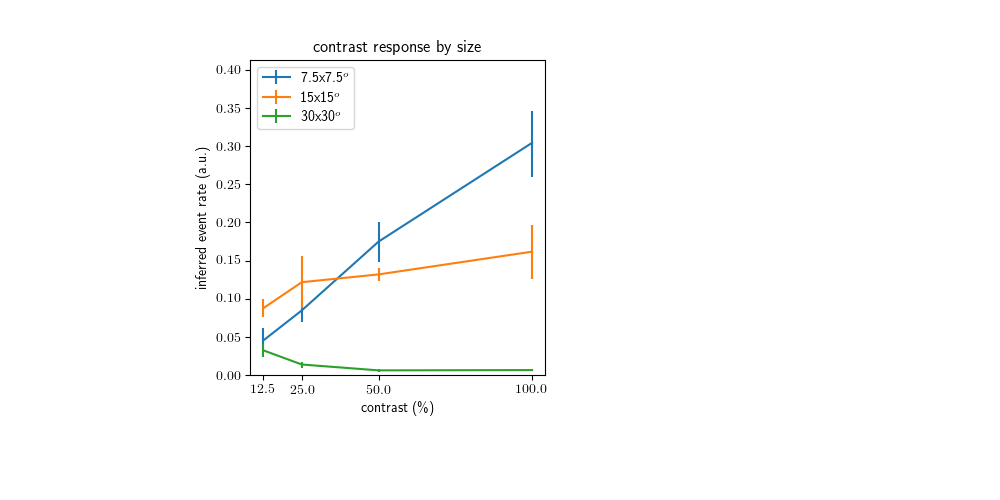

<IPython.core.display.Javascript object>


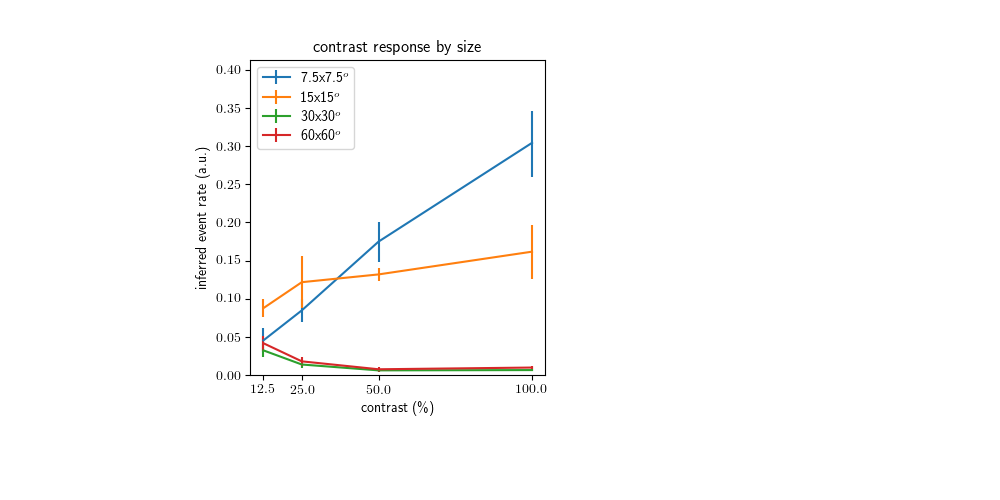

In [545]:
lb,ub = ut.bootstrap(Stavg[ontarget][thisind].mean(0),np.mean,pct=(16,84),axis=2)
mn,_ = ut.bootstrap(Stavg[ontarget][thisind].mean(0),np.mean,pct=(50,50),axis=2)
for j in range(Savg.shape[1]):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('contrast response by size')
    for i in range(j+1):
        yerr = np.concatenate((ub[:,i:i+1].T-mn[:,i:i+1].T,mn[:,i:i+1].T-lb[:,i:i+1].T),axis=0)
        plt.errorbar(100*ucontrast,mn[:,i],yerr=yerr)
#                 plt.errorbar(100*ucontrast,Stavg[ontarget][thisind].mean(0).mean(-1)[:,i],yerr=Stavg[ontarget][thisind].mean(0).std(-1)[:,i]/np.sqrt(5))
    plt.legend([r'7.5x7.5^o',r'15x15^o',r'30x30^o',r'60x60^o'],loc='upper left')
    plt.subplot(1,2,1)
    plt.xlabel(r'contrast (\%)')
    plt.ylabel(r'inferred event rate (a.u.)')
    plt.ylim(Stavg[ontarget][thisind].mean(0).min(),Stavg[ontarget][thisind].mean(0).max())
    locs, labels = plt.xticks()
    plt.xticks(100*ucontrast)
    plt.gcf().subplots_adjust(bottom=0.25,left=0.25)
    pylab.savefig('/home/mossing/excitation/thesis_mtg_18/contrastbysize'+str(j)+'.png')

<IPython.core.display.Javascript object>


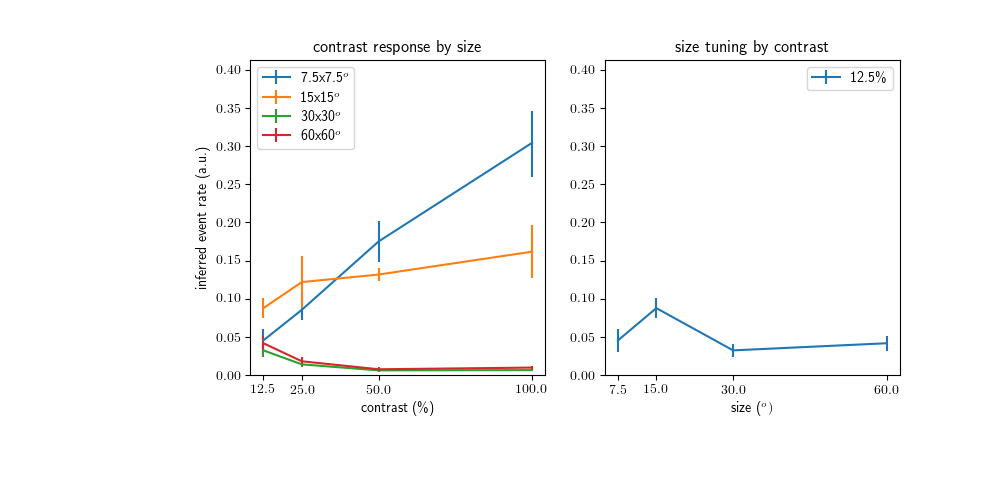

<IPython.core.display.Javascript object>


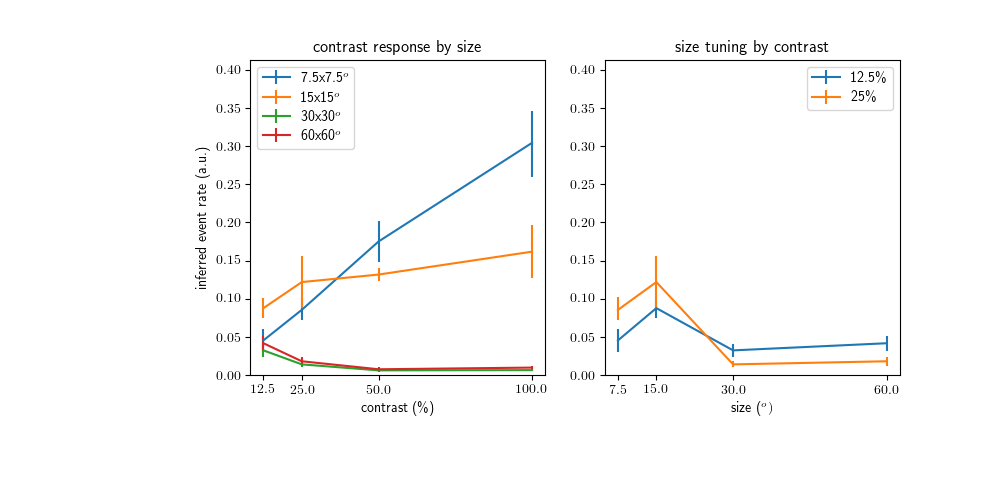

<IPython.core.display.Javascript object>


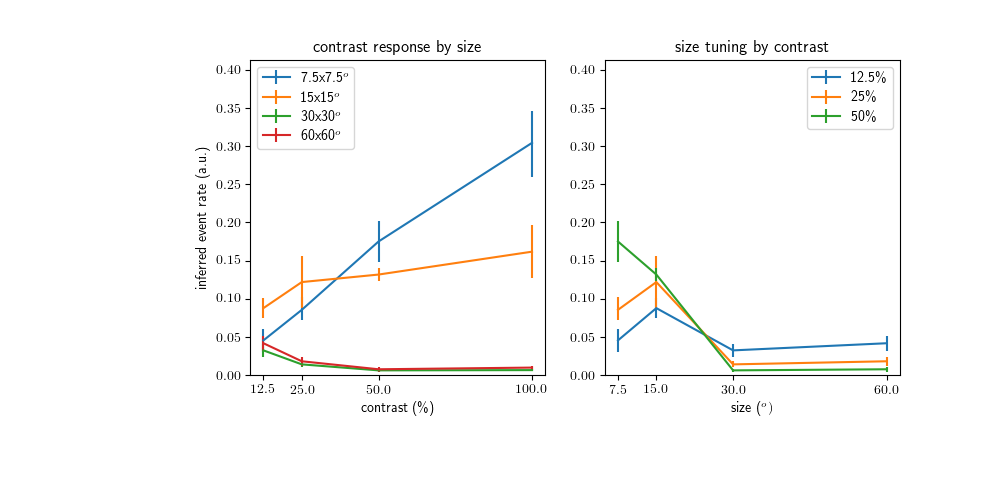

<IPython.core.display.Javascript object>


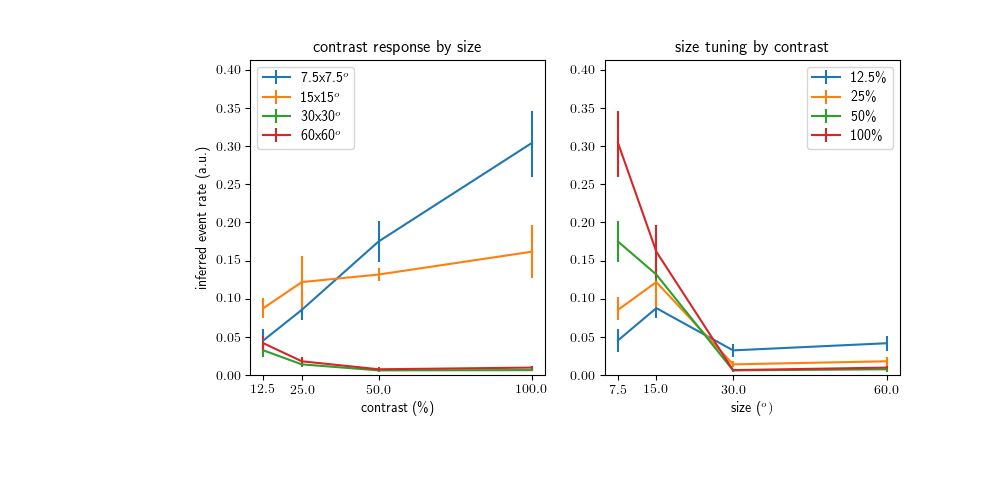

In [547]:
lb,ub = ut.bootstrap(Stavg[ontarget][thisind].mean(0),np.mean,pct=(16,84),axis=2)
mn,_ = ut.bootstrap(Stavg[ontarget][thisind].mean(0),np.mean,pct=(50,50),axis=2)
for j in range(Savg.shape[1]):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('contrast response by size')
    for i in range(Savg.shape[1]):
        yerr = np.concatenate((ub[:,i:i+1].T-mn[:,i:i+1].T,mn[:,i:i+1].T-lb[:,i:i+1].T),axis=0)
        plt.errorbar(100*ucontrast,mn[:,i],yerr=yerr)
#                 plt.errorbar(100*ucontrast,Stavg[ontarget][thisind].mean(0).mean(-1)[:,i],yerr=Stavg[ontarget][thisind].mean(0).std(-1)[:,i]/np.sqrt(5))
    plt.legend([r'7.5x7.5^o',r'15x15^o',r'30x30^o',r'60x60^o'],loc='upper left')
    plt.xlabel(r'contrast (\%)')
    plt.ylabel(r'inferred event rate (a.u.)')
    plt.ylim(Stavg[ontarget][thisind].mean(0).min(),Stavg[ontarget][thisind].mean(0).max())
    locs, labels = plt.xticks()
    plt.xticks(100*ucontrast)
    plt.gcf().subplots_adjust(bottom=0.25,left=0.25)
    plt.subplot(1,2,2)
    plt.title('size tuning by contrast')
    for i in range(j+1):
        yerr = np.concatenate((ub[i:i+1,:]-mn[i:i+1,:],mn[i:i+1,:]-lb[i:i+1,:]),axis=0)
        plt.errorbar(usize,mn[i,:],yerr=yerr)
#                 plt.errorbar(100*ucontrast,Stavg[ontarget][thisind].mean(0).mean(-1)[:,i],yerr=Stavg[ontarget][thisind].mean(0).std(-1)[:,i]/np.sqrt(5))
    plt.legend(['12.5\%','25\%','50\%','100\%'])
    plt.xlabel(r'size (^o)')
#     plt.ylabel(r'inferred event rate (a.u.)')
    plt.ylim(Stavg[ontarget][thisind].mean(0).min(),Stavg[ontarget][thisind].mean(0).max())
    locs, labels = plt.xticks()
    plt.xticks(usize)
    plt.gcf().subplots_adjust(bottom=0.25,left=0.25)
    pylab.savefig('/home/mossing/excitation/thesis_mtg_18/sizebycontrast'+str(j)+'.png')

In [526]:
Savg.shape

(1116, 4, 4)

In [486]:
Snorm = Savg/Savg.max(1).max(1)[:,np.newaxis,np.newaxis]

[[ 0.01293382  0.01636982  0.0221063   0.03006809]
 [ 0.01238178  0.01586464  0.02403925  0.034571  ]]


<IPython.core.display.Javascript object>


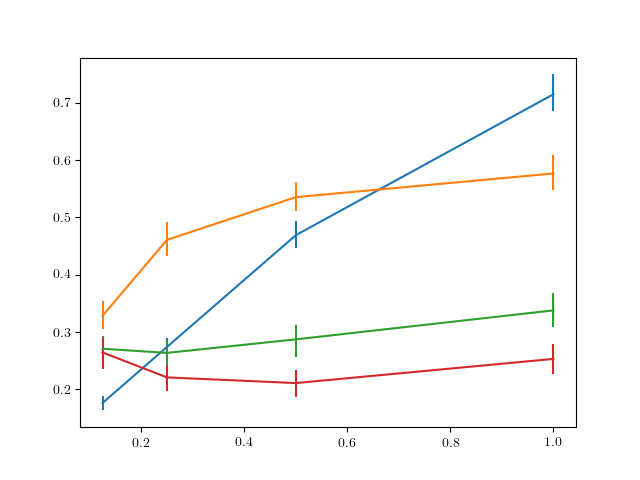

[[ 0.02306115  0.02821494  0.02383056  0.02925277]
 [ 0.02654383  0.03055522  0.02662667  0.03135686]]
[[ 0.02535887  0.02341042  0.03008361  0.02880618]
 [ 0.02221708  0.02284501  0.02570562  0.03082691]]
[[ 0.02934315  0.02300019  0.02423718  0.0259095 ]
 [ 0.02478025  0.02111117  0.02191675  0.02665077]]


In [519]:
lb,ub = ut.bootstrap(Snorm[ontarget],np.mean,pct=(16,84))
mn,_ = ut.bootstrap(Snorm[ontarget],np.mean,pct=(50,50))
for i in range(4):
    yerr = np.concatenate((ub[:,i:i+1].T-mn[:,i:i+1].T,mn[:,i:i+1].T-lb[:,i:i+1].T),axis=0)
    print(yerr)
    plt.errorbar(ucontrast,mn[:,i],yerr=yerr)

In [ ]:
def bootstrap_error_bars(ymeas,axis=0):
    for i in range(y)
    return y,yerr

<IPython.core.display.Javascript object>


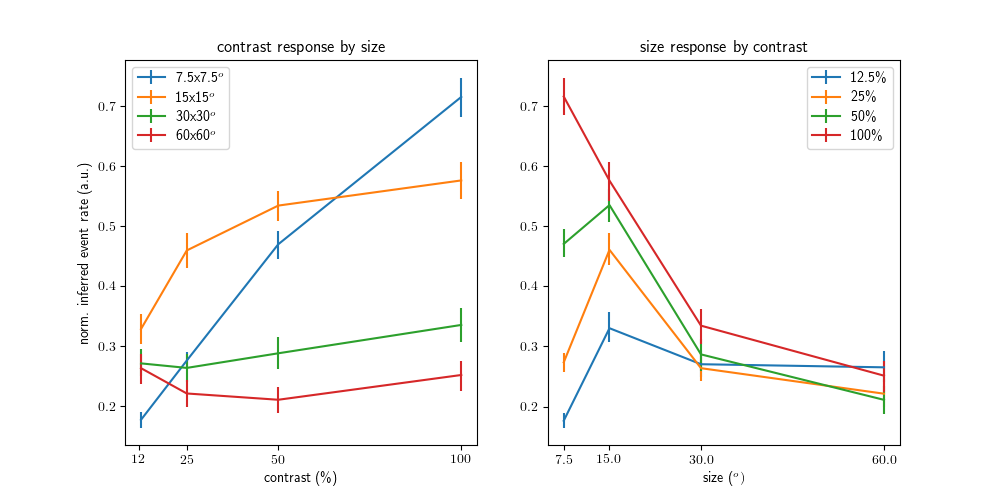

[[ 0.01131522  0.02301579  0.02148081  0.02428392]
 [ 0.01210904  0.02706827  0.02359306  0.02790253]]
[[ 0.01629456  0.02566275  0.02130142  0.02161824]
 [ 0.01486616  0.02818693  0.02408484  0.02361685]]
[[ 0.02230037  0.0279588   0.02791244  0.02305707]
 [ 0.02468099  0.0274127   0.02586354  0.02377184]]
[[ 0.03110597  0.03322466  0.0296736   0.02766897]
 [ 0.03164522  0.03127817  0.02774631  0.02508295]]
[[ 0.01287709  0.01480405  0.02391411  0.03311229]
 [ 0.01263734  0.01500208  0.02251097  0.03246859]]
[[ 0.02439428  0.02897998  0.02565671  0.03087999]
 [ 0.02586508  0.0293924   0.02518474  0.0302683 ]]
[[ 0.02149434  0.02323463  0.02652856  0.02868361]
 [ 0.02390529  0.02312597  0.02707689  0.02903438]]
[[ 0.02716154  0.02216517  0.02187191  0.0274334 ]
 [ 0.02343059  0.02198579  0.02128437  0.02354605]]


In [573]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,2)
plt.title('size response by contrast')
lb,ub = ut.bootstrap(Snorm[ontarget],np.mean,pct=(16,84))
mn,_ = ut.bootstrap(Snorm[ontarget],np.mean,pct=(50,50))
for i in range(Savg.shape[1]):
#     plt.errorbar(usize,Snorm[ontarget].mean(0).T[:,i],yerr=Snorm[ontarget].std(0).T[:,i]/np.sqrt(ontarget.sum()))#/np.sqrt(ontarget.sum()))
    yerr = np.concatenate((ub[i:i+1,:]-mn[i:i+1,:],mn[i:i+1,:]-lb[i:i+1,:]),axis=0)
    print(yerr)
    plt.errorbar(usize,mn[i,:],yerr=yerr)
plt.legend(['12.5\%','25\%','50\%','100\%'])
plt.xlabel(r'size (^o)')
locs, labels = plt.xticks()
plt.xticks(usize)
plt.subplot(1,2,1)
plt.title('contrast response by size')
lb,ub = ut.bootstrap(Snorm[ontarget],np.mean,pct=(16,84))
mn,_ = ut.bootstrap(Snorm[ontarget],np.mean,pct=(50,50))
for i in range(Savg.shape[2]):
#     plt.errorbar(100*ucontrast,Snorm[ontarget].mean(0)[:,i],Snorm[ontarget].std(0)[:,i]/np.sqrt(ontarget.sum()))
    yerr = np.concatenate((ub[:,i:i+1].T-mn[:,i:i+1].T,mn[:,i:i+1].T-lb[:,i:i+1].T),axis=0)
    print(yerr)
    plt.errorbar(100*ucontrast,mn[:,i],yerr=yerr)
plt.legend(['7.5x7.5^o','15x15^o','30x30^o','60x60^o'])
plt.xlabel(r'contrast (\%)')
# plt.ylabel('inferred event rate (a.u.)')
locs, labels = plt.xticks()
plt.ylabel('norm. inferred event rate (a.u.)')
plt.xticks((100*ucontrast).astype(np.uint16))
pylab.savefig('/home/mossing/excitation/thesis_mtg_18/size_contrast_popsummary.png')

<IPython.core.display.Javascript object>


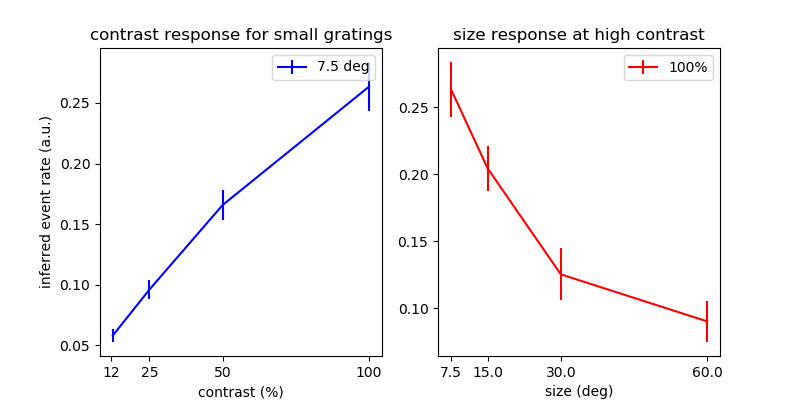

([<matplotlib.axis.XTick at 0x7f78354e19b0>,
 <a list of 4 Text xticklabel objects>)

In [432]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,2)
plt.title('size response at high contrast')
for i in range(3,4): #Savg.shape[1]):
    plt.errorbar(usize,Savg[ontarget].mean(0).T[:,i],yerr=Savg[ontarget].std(0).T[:,i]/np.sqrt(ontarget.sum()),c='r')#/np.sqrt(ontarget.sum()))
plt.legend(['100%']) #, '12.5%','25%','50%','100%'])
plt.xlabel('size (deg)')
locs, labels = plt.xticks()
plt.xticks(usize)
plt.subplot(1,2,1)
plt.title('contrast response for small gratings')
for i in range(1): #Savg.shape[2]):
    plt.errorbar(100*ucontrast,Savg[ontarget].mean(0)[:,i],Savg[ontarget].std(0)[:,i]/np.sqrt(ontarget.sum()),c='b')
plt.legend(['7.5 deg']) #,'15 deg','30 deg','60 deg'])
plt.xlabel('contrast (%)')
# plt.ylabel('inferred event rate (a.u.)')
locs, labels = plt.xticks()
plt.ylabel('inferred event rate (a.u.)')
plt.xticks((100*ucontrast).astype(np.uint16))

<IPython.core.display.Javascript object>


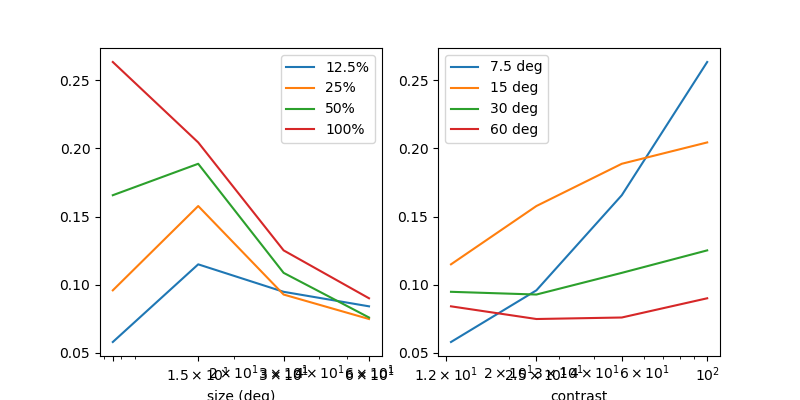

([<matplotlib.axis.XTick at 0x7f780dc1f7b8>,
 <a list of 4 Text xticklabel objects>)

In [413]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.semilogx(usize,Savg[ontarget].mean(0).T)
plt.legend(['12.5%','25%','50%','100%'])
plt.xlabel('size (deg)')
locs, labels = plt.xticks()
plt.xticks(usize)
plt.subplot(1,2,2)
plt.semilogx(100*ucontrast,Savg[ontarget].mean(0))
plt.legend(['7.5 deg','15 deg','30 deg','60 deg'])
plt.xlabel('contrast')
locs, labels = plt.xticks()
plt.xticks((100*ucontrast).astype(np.uint16))

In [293]:
np.logspace(-1,0,6)

array([ 0.1       ,  0.15848932,  0.25118864,  0.39810717,  0.63095734,  1.        ])

In [298]:
np.logspace(np.log10(5),np.log10(60),6)

array([  5.        ,   8.21875915,  13.50960039,  22.20643035,
        36.50186051,  60.        ])

<IPython.core.display.Javascript object>


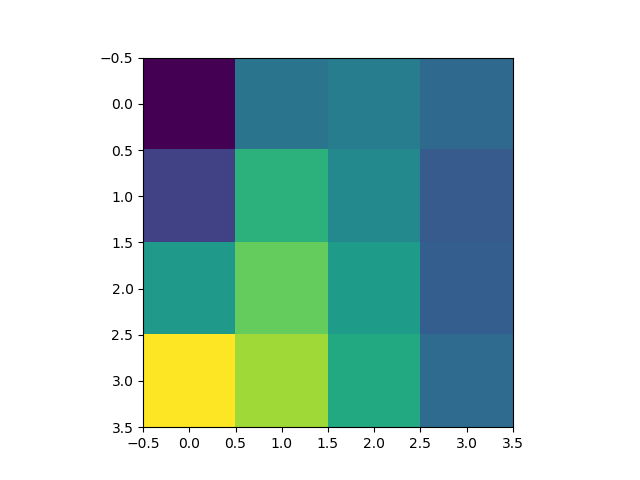

In [194]:
plt.imshow(Savg[ontarget].sum(0))

In [325]:
x = np.linspace(0,5,1000)
sa = 1
sb = 3
def dog(x,a,b):
    return (a*np.exp(-x**2/sa**2)/sa-b*np.exp(-x**2/sb**2)/sb)/np.sqrt(2*np.pi)

<IPython.core.display.Javascript object>


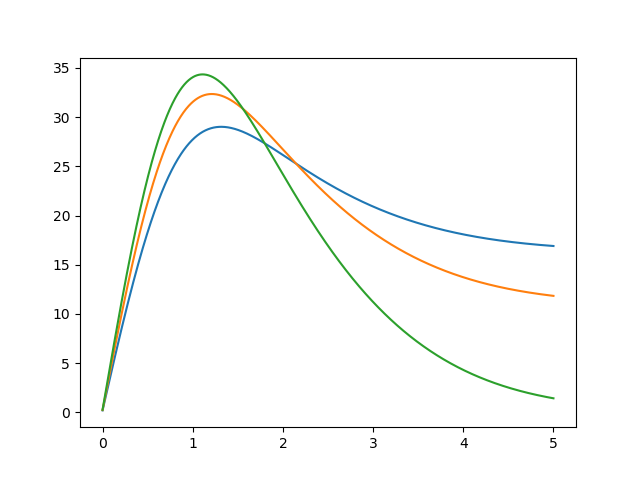

In [328]:
beta = 0.8
plt.plot(x,np.cumsum(dog(x,beta**2,beta**4)))
beta = 0.9
plt.plot(x,np.cumsum(dog(x,beta**2,beta**4)))
beta = 1
plt.plot(x,np.cumsum(dog(x,beta**2,beta**4)))

<IPython.core.display.Javascript object>


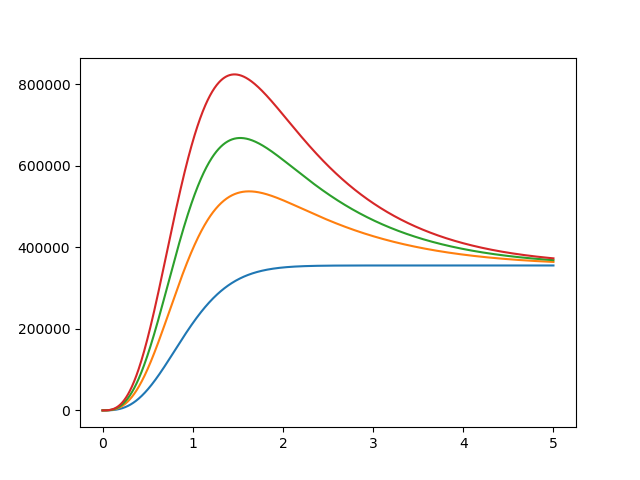

In [356]:
b = 0.0
a = b+1
plt.plot(x,np.cumsum(dog(x,a,b))**3)
b = 0.4
a = b+1
plt.plot(x,np.cumsum(dog(x,a,b))**3)
b = 0.6
a = b+1
plt.plot(x,np.cumsum(dog(x,a,b))**3)
b = 0.8
a = b+1
plt.plot(x,np.cumsum(dog(x,a,b))**3)

/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


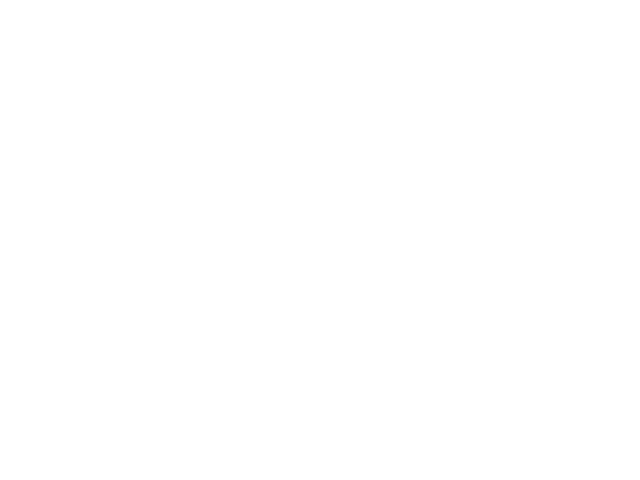

<function matplotlib.pyplot.contour>

In [1767]:
xx,yy = np.meshgrid(np.linspace(0,1,1000),np.linspace(0,1,1000))
plt.figure()
plt.contour

In [480]:
def weight(x,y):
    return 2.02*np.exp(-(yy-1)**2-xx**2)-1.01

In [502]:
def weight(x,y):
    return (2.02*np.exp(-(yy-1)**2-xx**2)-1.01 - 0.5*(2.02*np.exp(-(yy-1)**2-(xx-2)**2)-1.01))-0.5

In [1754]:
def weight(s1,Cs1s2):
    return -s1/2 + Cs1s2/4

In [1810]:
n = 2.5
a = 1
def weight(s1,Cs1s2):
    Es2 = 0.5 + Cs1s2*(s1-0.5)
    return -n*s1*Es2**(n-1)/(a**n+Es2**n)**2 + Cs1s2*(1/(a**n+Es2**n) - n*Es2**n/(a**n+Es2**n)**2)

/home/mossing/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


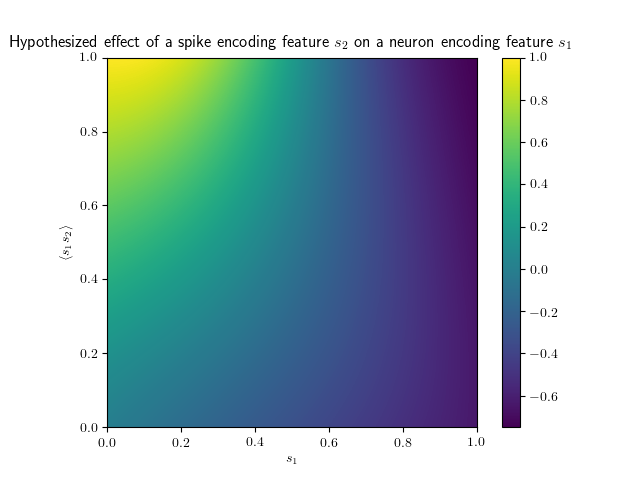

Text(0.5,1,'Hypothesized effect of a spike encoding feature $s_2$ on a neuron encoding feature $s_1$')

In [1814]:
rc('text', usetex=True)
plt.figure()
plt.imshow(weight(xx,yy),origin='lower',cmap='viridis',extent=[0,1,0,1])
plt.colorbar()
# plt.contour(xx,yy,weight(xx,yy),30)
# plt.axis('equal')
# plt.axis('tight')
# plt.axis('off')
plt.ylabel(r'$\langle s_1 s_2 \rangle$')
plt.xlabel(r'$s_1$')
plt.title('Hypothesized effect of a spike encoding feature $s_2$ on a neuron encoding feature $s_1$')

In [438]:
yy.min()

-1.0

In [643]:
rdot(r0)

array([ 0.01,  0.01])

In [605]:
def redot(re,ri):
    return -re + (wee*re+wei*ri+he)**ne
def ridot(re,ri):
    return -ri + (wie*re+wii*ri+hi)**ni

In [726]:
wee*wii-wei*wie

24

In [632]:
np.linalg.det(W)

2.9999999999999996

In [631]:
W

array([[ 1,  2],
       [-2, -1]])

In [617]:
re0 = 0
ri0 = 0

In [618]:
t = np.arange(0,T+dt,dt)

In [619]:
t.shape

(10001,)

In [620]:
re = np.zeros_like(t)
ri = np.zeros_like(t)
re[0] = re0
ri[0] = ri0

In [621]:
for i in range(t.shape[0]-1):
    re[i+1] = re[i] + dt*redot(re[i],ri[i])
    ri[i+1] = ri[i] + dt*ridot(re[i],ri[i])

In [622]:
t.shape

(10001,)

<IPython.core.display.Javascript object>


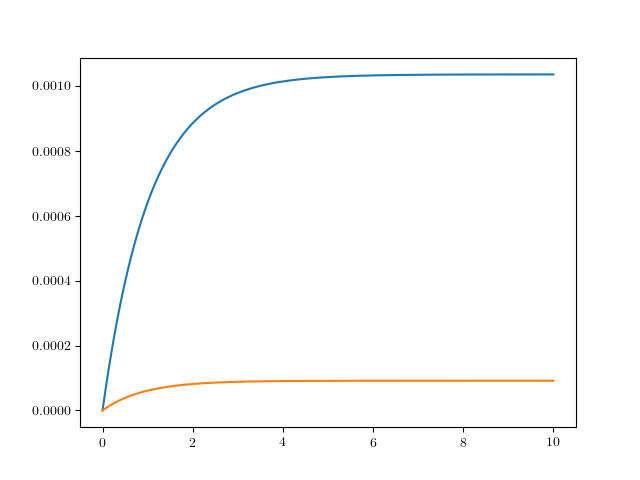

In [623]:
plt.plot(t,re)
plt.plot(t,ri)

In [876]:
gridno = 100
ha = np.linspace(0.02,0.5,gridno)
p = np.zeros((gridno,2))
wee = 1
for i in range(gridno):
    h = ha[i]*np.array((1,1))
    W = np.array(((wee,wei),(wie,wii)))
    p[i] = sop.fixed_point(rdot,r0)

RuntimeError: Failed to converge after 500 iterations, value is [-1.02936135 -1.22490638]

<IPython.core.display.Javascript object>


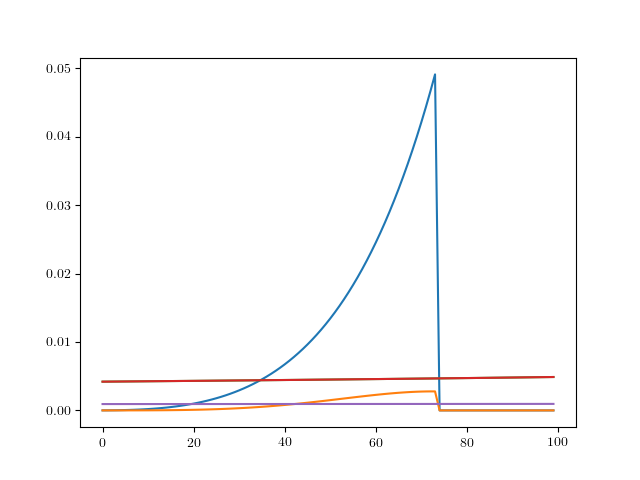

In [877]:
plt.figure()
plt.plot(p)

In [732]:
i

12

In [3]:
W

NameError: name 'W' is not defined

In [4]:
W.dot(np.array((1,1)))

NameError: name 'W' is not defined

In [17]:
gridno = 100
wa = np.linspace(0,3,gridno)
p = np.zeros((gridno,2))
for i in range(gridno):
    h = 0.2*np.array((1,0.05))
    wee = wa[i]
    W = np.array(((wee,wei),(wie,wii)))
    p[i] = sop.fixed_point(rdot,r0)

NameError: name 'K' is not defined

In [18]:
p.shape

(100, 2)

<IPython.core.display.Javascript object>


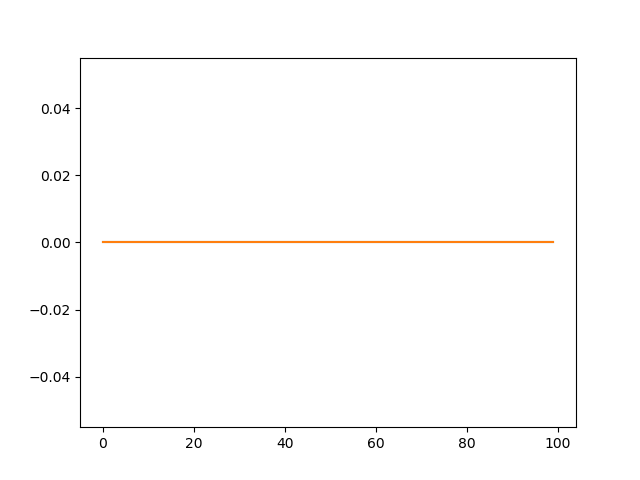

In [20]:
plt.figure()
plt.plot(p)

In [22]:
wee = 1
W = np.array(((0,wee,wei),(wee,0,wei),(wie,wie,wii)))
np.linalg.det(W)

-87.0

In [23]:
r0 = np.array((0,0,0))
h = np.array((1,1,1))

In [24]:
def rdot(r):
    fre = K[0]*(-r[0] + (W.dot(r)+h)[0]**ne)
    fri = K[1]*(-r[1] + W.dot(r)+h)[1]**ni
    return -r + np.array((fre,fri))

In [102]:
ne = 1
ni = 1
wee = 2
wei = -4
wie = 5
wii = -7
he = 1
hi = 1

re0 = 0
ri0 = 0

dt = 1e-3
T = 10

n = 2
W = np.array(((wee,wei),(wie,wii)))
h = np.array((he,hi))
r0 = np.array((re0,re0,ri0))
K = np.array((1,1,5))

In [103]:
def rdot(r):
    fre0 = K[0]*(W.dot(r)+h)[0]**ne
    fre1 = K[1]*(W.dot(r)+h)[1]**ne
    fri = K[2]*(W.dot(r)+h)[2]**ni
    return -r + np.array((fre0,fre1,fri))

In [104]:
W = np.array(((0,wee,wei),(wee,0,wei),(wie,wie,wii)))
W

array([[ 0,  2, -4],
       [ 2,  0, -4],
       [ 5,  5, -7]])

In [105]:
np.linalg.det(W)

-51.999999999999986

In [106]:
r0

array([0, 0, 0])

In [107]:
gridno = 100
wa = np.linspace(0,4,gridno)
grid2no = 3
p = np.zeros((gridno,grid2no,3))
for k in range(grid2no):
    print(k)
    for i in range(gridno):
        print(i)
        h = 0.06*(k+1)*np.array((1,1,0))
        wee = wa[i]
        W = np.array(((0,wee,wei),(wee,0,wei),(wie,wie,wii)))
        p[i,k] = sop.fixed_point(rdot,r0)

0
0


RuntimeError: Failed to converge after 500 iterations, value is [ -7.21392121e+105  -7.21392121e+105  -9.74854218e+105]

In [40]:
p.shape

(100, 3, 3)

<IPython.core.display.Javascript object>


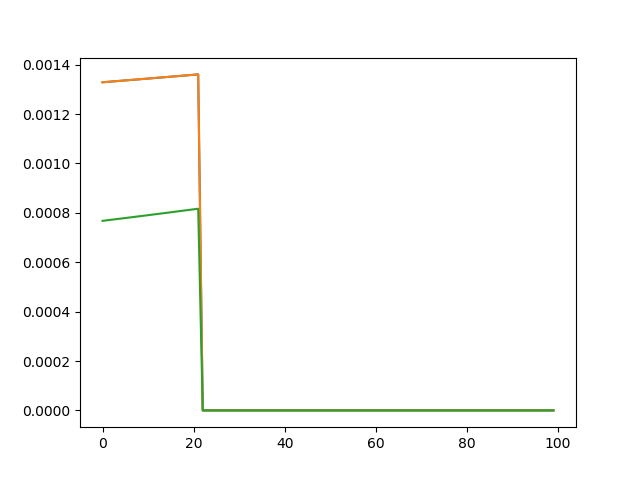

In [41]:
plt.plot(p[:,0,:])

<IPython.core.display.Javascript object>


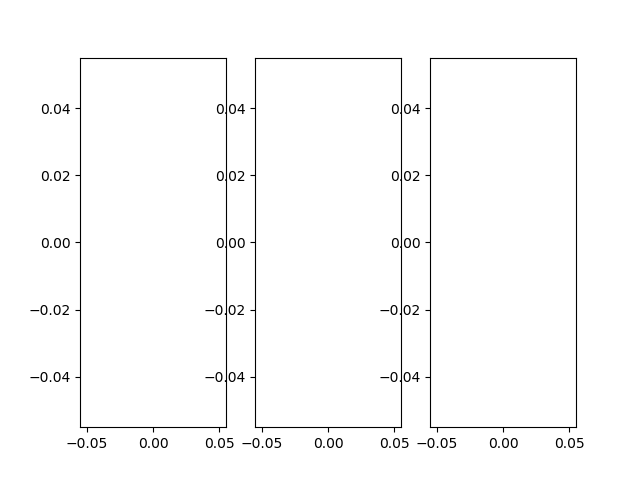

/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [38]:
plt.figure()
for k in range(grid2no):
    plt.subplot(1,grid2no,k+1)
    plt.plot(p[:,k]/p[:,k].min(0))

In [331]:
he = 1
hi = 1


ne = 2
ni = 3
wee = 2
wei = -6
wie = 6
wii = -1

def compute_nullclines(he,hi):

# re0 = 0
# ri0 = 0

# dt = 1e-3
# T = 10

    W = np.array(((wee,wei),(wie,wii)))
    h = np.array((he,hi))
    r0 = np.array((re0,re0,ri0))
    K = np.array((1,5))

    def rdot(r):
        fre = K[0]*(-r[0] + 1*np.maximum((W.dot(r)+h)[0]**ne,0))
        fri = K[1]*(-r[1] + 2*np.maximum((W.dot(r)+h)[1]**ni,0))
        return np.array((fre,fri))

    def redot(re,ri):
        return rdot(np.array((re,ri)))[0]

    ngrid = 100
    gridrI = np.linspace(0.15,2,ngrid)
    nullclineE = np.zeros_like(gridrI)
    for i in range(ngrid):
        rival = gridrI[i]
        f = lambda x : redot(x,rival)
        nullclineE[i] = sop.newton(f,0.0)

    ngrid = 100
    gridrE = np.linspace(0,nullclineE.max(),ngrid)
    nullclineI = np.zeros_like(gridrE)
    for i in range(ngrid):
        rival = gridrE[i]
        f = lambda x : redot(rival,x)
        nullclineI[i] = sop.newton(f,0.0)
    
    return nullclineE,nullclineI,gridrE,gridrI

<IPython.core.display.Javascript object>


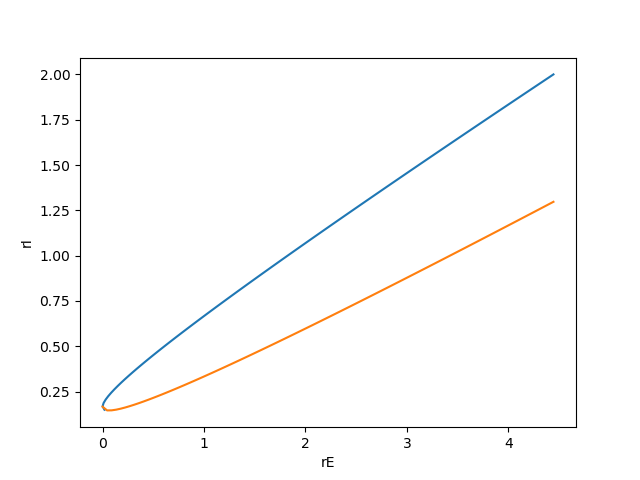

Text(0,0.5,'rI')

In [332]:
nullclineE,nullclineI,gridrE,gridrI = compute_nullclines(1,1)

plt.plot(nullclineE,gridrI)
plt.plot(gridrE,nullclineI)
plt.xlabel('rE')
plt.ylabel('rI')

# nullclineE,nullclineI,gridrE,gridrI = compute_nullclines(1,3)

# plt.plot(nullclineE,gridrI)
# plt.plot(gridrE,nullclineI)
# plt.xlabel('rE')
# plt.ylabel('rI')

<IPython.core.display.Javascript object>


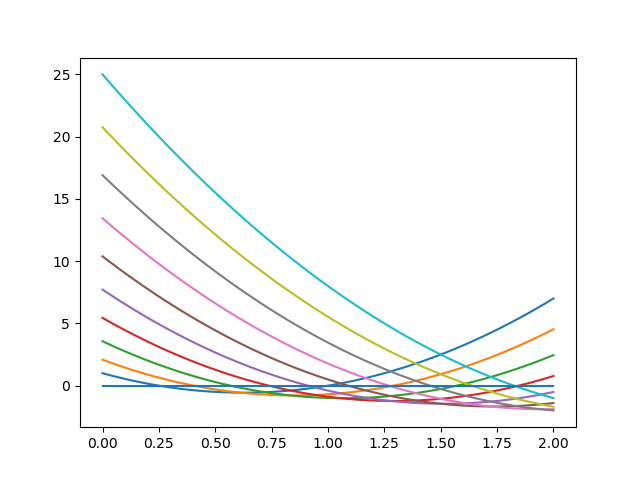

In [254]:
plt.figure()
x = np.linspace(0,2,100)
rd = np.zeros_like(x)
for y in np.linspace(0.5,1.5,10):
    for i in range(rd.shape[0]):
        rd[i] = redot(x[i],y)
    plt.plot(x,rd)
plt.plot(x,np.zeros_like(x))

<IPython.core.display.Javascript object>


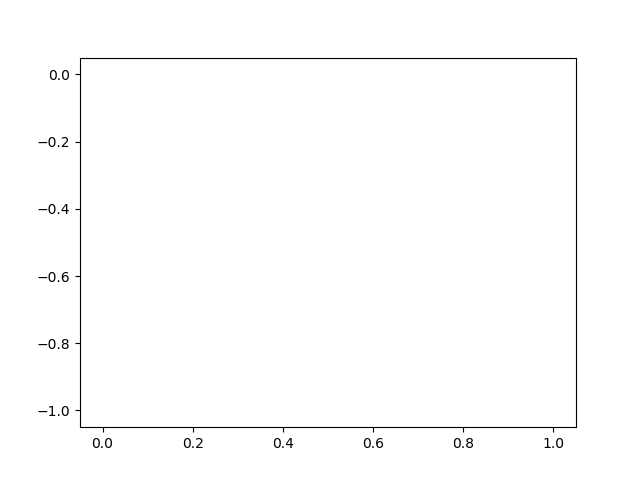

In [118]:
plt.plot(rigrid,nullcline)

In [120]:
nullcline.max()

-1